# 3'READS+ Pipeline (Part 2)
**This notebook is the Part 2 of the 3'READS+ pipeline, which will map poly(A) sites identified in Part-1 to different genomic features, extract RNA and sequence features based on information pulled from different databases, and calculate experiment outcomes.** The resultant dataframe _pas_ can be used as input for building machine learning models in Part-3. More specifically, this notebook will do the following:

1. Register settings for this analysis. One experiment can be analysed with different settings (parameters). The results for each setting will be saved in different folders under the *result_dir* directory. 
2. Extend annotated 3'UTR regions to allow identification of new pA sites in previously poorly annotated 3'UTRs. 
3. Assign pA clusters identified in Part 1 to genomic features such as extended 3'UTRs, introns, CDSs, and 5'UTRs.
4. Resolve pA sites mapped to multiple genes.
5. Map intergenic and intronic pA sites to Non-Coding RNAs (ncRNAs).
6. Map remaining intergenic pA sites to Upstream Antisense RNAs (uaRNAs).
7. Plot the fractions of pA sites and PASS reads mapped to the mitochondria genome.
8. Resolve pA sites mapped to multiple genomic features of alternatively spliced gene.
9. Plot distribution of pA sites and PASS reads in different genomic features of each sample.
10. Plot nucleotide profile near pA sites mapped to different genomic regions.
11. Calculate optimal Transcript Starting Sites (TSSs).
12. Calculate CDS, intronic, 5'UTR, 3'UTR, and ncRNA features (such as size, GC content, and uORF) and check their relationships.
13. Identify subtypes of pA sites.
14. Identify poly(A) signal (PAS).
15. Check if different subtypes of pA sites tend to use different poly(A) signal (PAS).
16. Get symbols and Entrez gene ids.
17. Calculate gene expression-related features, such as pA site level RPM, gene level RPM, and pA site usage.
18. Filter out lowly expressed 3'UTR pAs.
19. Number of pA sites per gene and its relationship with 3'UTR and CDS GC%.
20. Minimum Folding Energy (MFE) of exonic 3'UTR sequences.
21. Features of mRNAs encoding differentially localized proteins.
22. Calculate RBP binding scores using RNAcompete and SELEX data downloaded from ATtRACT.
23. Annotate Alu and IRAlu elements (human samples only).
24. Use DESeq2 to transform data and calcualte pA site fold change (FC).


**Required softwares**

 * dzlib.R, mfe.py, and process_MetazSecKB.R in the [modules](https://github.com/DinghaiZ/3-prime-READS-plus/tree/master/modules) folder 
 * Jupyter Lab or Jupyter Notebook for runing this notebook
 * Linux environment
 
**Hardware requirements**
 * Muticore CPU for parallel computing

## 1. Set configurations specific to this analysis
These parameters need to be specified for different projects and experiments. One experiment can be analysed with different settings. 

In [1]:
MODULE_DIR = "/home/dinghai/dev/3-prime-READS-plus/modules"

# SHARED_DATA_DIR is a directory containing frequently used data, such as annotation databases.
SHARED_DATA_DIR = '/home/dinghai/projects/fud'

# Each data set can be analyzed with different parameter settings
SETTING = 'NC'

In [2]:
# If I am in the development directory
if(getwd()=='/home/dinghai/dev/3-prime-READS-plus/projects/project_1/experiment_1/notebooks'){
  SETTING = 'NC'
}

if(SETTING == 'NC'){
  # Which genome was used for mapping?  
  GENOME = 'mm9' # Genome name, currently either mm9 or hg19
  # Define which sample conditions to focus on
  # As mentioned in Part-1 of the pipeline, sample names should be in the format of 
  # "Treatment_Fraction_Batch", such as in "NT_C_1" and "NT_N_1".
  TREATMENTS = c("NT") # Order matters. Earlier ones will be reference
  FRACTIONS = c("C", "N") # Order matters. Earlier ones will be reference 
  COMPARISONS = c("N_C") # Comparisons to make: N vs C
    
  # Use unique PASS reads for analysis?
  uPASS = F 
  if(uPASS){
    cluster_file = paste0('../results/clusters.using.unique.reads.csv')
    cluster_min_count = 2
  }else{
    cluster_file = paste0('../results/clusters.using.all.reads.csv')
    cluster_min_count = 5
  }
    
  # Settings for filtering low expression pAs 
  lowest_usage = 0 # Percentage 
  lowest_rpm = 0 # 
  lowest_count = 5
  filter_strength = 1 # Fraction of samples satisfying the filters
    
  # When a pA site map to mutlple genomic features of the same gene due to alternative splicing,
  # should we simplify the "region" annotation? 
  simplify_region_annotation = T
  
  # Settings for identifying aUTRs
  neighbor = F # Calculate aUTRs for each neighboring isoforms?
  toptwo = T # Pick top two isoforms for each gene?
  
  # Number of CPUs for parallel computing 
  MAX_WORKERS = 8  
}

In [3]:
result_dir = paste0("../results/", SETTING)
system(paste0("mkdir ", result_dir))
cat("Analysis results will be saved in the following directory:", result_dir) 

Analysis results will be saved in the following directory: ../results/NC

Load packages:

In [5]:
oldw = getOption("warn")
options(warn = -1)
require(tidyr)
require(magrittr)
require(dplyr)
require(ggplot2)
require(ggpubr)
require(plotly)
require(gplots)
require(GenomicFeatures)
require(GenomicRanges)
require(Biostrings)
require(docstring)
require(foreach)
require(doParallel)
registerDoParallel(MAX_WORKERS)
theme_set(theme_bw(base_size = 15) + theme(plot.title = element_text(hjust = 0.5)))
require(repr)
require(RColorBrewer)

# Depending on the genome, load the right packages:
if(GENOME == "mm9"){
  require("org.Mm.eg.db")
  org.db = org.Mm.eg.db
  txdb_path = file.path(SHARED_DATA_DIR, "mm9.refGene.txdb.sqlite")
  BSspec = "Mmusculus"
}else if(GENOME == "hg19"){
  require("org.Hs.eg.db")
  org.db = org.Hs.eg.db
  txdb_path = file.path(SHARED_DATA_DIR, "hg19.refGene.txdb.sqlite")
  BSspec = "Hsapiens"
}
    
BSgeno = paste0("BSgenome.", BSspec, ".UCSC.", GENOME)
require(BSgeno, character.only = T) 

options(warn = oldw)

If the txdb has not been downloaded yet, download it and save it to the shared data directory:

In [6]:
tryCatch(
  {txdb = loadDb(txdb_path)},
  error = function(e){
    txdb = makeTxDbFromUCSC(genome = GENOME, tablename = 'refGene')
    saveDb(txdb, file.path(SHARED_DATA_DIR, paste0(GENOME, ".refGene.txdb.sqlite")))
  }
)

Load custom functions defined in *dzlib.R*:

In [8]:
oldw = getOption("warn")
options(warn = -1)

source("/home/dinghai/dev/3-prime-READS-plus/modules/dzlib.R")

options(warn = oldw)

## 2. Extend annotated 3'UTR regions to allow identification of new pA sites in poorly annotated 3'UTRs. 

First, define a helper function that will be reused several times later. 

In [186]:
rename_grl = function(grl, old_key = "ACCNUM", new_key = "SYMBOL"){
    #' A function to rename GRanges in a GRangeList.
    
    # Convert a GRangeList to a GRanges for faster calculation
    gr = unlist(grl)

    # Convert the accession numbers of the genes into gene symbols
    names(gr) = mapIds(org.db, keys = names(gr), keytype = old_key, column = new_key)
    
    # Rebuild GRanges by gene symbol 
    grl = split(gr, names(gr))   

    # Collapse features
    grl = reduce(grl)
    
    # Remove GRanges that are on two strands
    grl[sapply(grl, function(x) length(strand(x)@values) == 1)]
}

To extend 3'UTRs, I first get 4 kb regions downstream of annotated 3'UTRs. If the downstream regions overlap with downstream genes, I'll shrink the downstream regions to avoid overlaps. On the other hand, if the beginnings of the downstream regions are located within any genes (e.g. intronic 3'UTRs), I will undo the extension by setting the start and end of the extension to be identical. Downstream regions are processed separately for 3'UTRs on the plus and minus strands. Finally, the 3'UTRs and downstream regions are combined to get extended 3'UTRs. **Please note that the extended 3'UTRs are just candidate 3'UTR regions. The exact 3'UTR boundaries will be determined by pA sites that can be mapped to them.**

In [187]:
# Get 3'UTR annotation from Refseq
threeUTRs = suppressWarnings(threeUTRsByTranscript(txdb, use.names=T))

# Rename the 3'URs with gene symbols
threeUTRs = rename_grl(threeUTRs, old_key = "ACCNUM", new_key = "SYMBOL")

# Convert to GRanges for later use
utr3 = unlist(threeUTRs)

# Get 4 kb downstream regions. 3'UTR regions not included
# Out of boundary regions need to be trimmed
ds = trim(suppressWarnings(flank(utr3, 4000, start=F)))

# Get GRanges for genes
genes = genes(txdb, filter=NULL, single.strand.genes.only=T)
 
# Find extensions that overlap with genes on positive strands:
olp = findOverlaps(ds[strand(ds) == "+"], genes[strand(genes) == "+"])

# Which 3'UTRs have been extended too far?
extended_into_genes = start(ds[strand(ds) == "+"][queryHits(olp)]) < 
                      start(genes[strand(genes) == "+"][subjectHits(olp)])

# Reset the extended region so that the extended region no longer overlap with genes
end(ds[strand(ds) == "+"][queryHits(olp)][extended_into_genes]) =
    start(genes[strand(genes) == "+"][subjectHits(olp)][extended_into_genes]) - 1 

# If the bebinning of 3'UTR downstream region is located within any genes, don't extend either.
width(ds[strand(ds) == "+"][queryHits(olp)][!extended_into_genes]) = 1 

# Find extensions that overlap with genes on negative strands:
olp = findOverlaps(ds[strand(ds) == "-"], genes[strand(genes) == "-"])

# Which 3'UTRs have been extended too far?
extended_into_genes = end(ds[strand(ds) == "-"][queryHits(olp)]) > 
                      end(genes[strand(genes) == "-"][subjectHits(olp)])

# Reset the extended region so that the extended region no longer overlap with genes
start(ds[strand(ds) == "-"][queryHits(olp)][extended_into_genes]) = 
    end(genes[strand(genes) == "-"][subjectHits(olp)][extended_into_genes]) + 1 

# If the bebinning of 3'UTR downstream region is located within any genes, don't extend either.
end(ds[strand(ds) == "-"][queryHits(olp)][!extended_into_genes]) = 
    start(ds[strand(ds) == "-"][queryHits(olp)][!extended_into_genes]) 

# Combind previous 3'UTR definition with the downstream region to define extended 3'UTRs
utr3 = resize(utr3, width = width(utr3) + width(ds)-1, fix="start")

# Rebuild 3'UTRs named by gene symbol 
threeUTRs = split(utr3, names(utr3))

'select()' returned 1:1 mapping between keys and columns


The above code will generate some warning messages. The second warning message was produced by the flank() function, but the trim() function will take care of the issue. Take a look at how the size of extensions distribute:

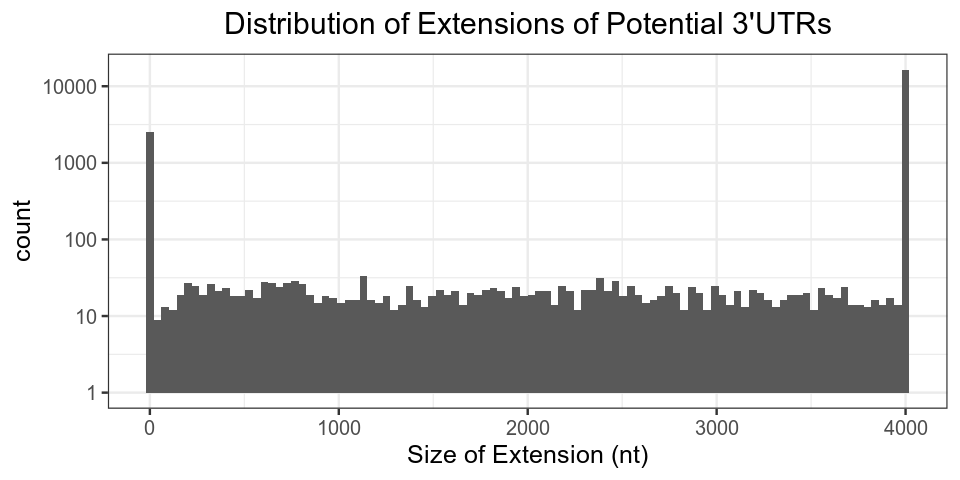

In [188]:
df = data.frame(extended = width(ds)) 

options(repr.plot.width=8, repr.plot.height=4)

ggplot(df, aes(extended)) +
  geom_histogram(bins=100) +
  scale_y_log10() +
  xlab("Size of Extension (nt)") +
  ggtitle("Distribution of Extensions of Potential 3'UTRs")

## 3.1. Read the pA cluster file created in Part-1 of the pipeline and create a GRange:
Only read data for the samples defined in Step 1. 

In [189]:
# Calculate sample names and batch numbers
header = strsplit(readLines(cluster_file, n = 1), ",")[[1]]

sample_names = grep(paste0("(", paste0(TREATMENTS, collapse="|"), 
                           ")_(", paste0(FRACTIONS,collapse="|"), 
                           ")_\\d+"), 
                    header[-c(1:3)], value = T)

batches = unique(sub(".+_(\\d+.?)$", "\\1", sample_names)) 

cat(paste0("The following samples will be used for the analysis named '", SETTING, "':")) 
sample_names

The following samples will be used for the analysis named 'NC':

[1] "NT_C_1" "NT_C_2" "NT_C_3" "NT_N_1" "NT_N_2" "NT_N_3"

In [190]:
# Only read desirable columns of the cluster file
cluster = read.csv(cluster_file)[, c("chromosome","strand","position", sample_names)]

# Require at least cluster_min_count reads for more than 2 samples
cluster = subset(cluster, rowSums(cluster[,-c(1:3)] >= cluster_min_count) >= 2)

# Create a GRanges object
pA = GRanges(seqnames = cluster$chromosome, strand = cluster$strand,
             ranges = IRanges(start = cluster$position, end = cluster$position))

mcols(pA, use.names = T) = cluster[,-c(1:3)]

rm(cluster)

## 3.2. Map the pA sites to extended 3'UTRs

In [191]:
pA$gene_symbol = ""
pA$region = ""
olp = findOverlaps(pA, threeUTRs)
pA[queryHits(olp), ]$gene_symbol = names(threeUTRs[subjectHits(olp)])
pA[queryHits(olp), ]$region = "3UTR"

## 3.3. Map the pA sites to introns
Code for steps 3.3 ~ 3.5 can be refactored later, since the steps are similar.

In [192]:
# Get intron annotation
introns = suppressWarnings(intronsByTranscript(txdb, use.names=T))

# Use the previously defined helper function to rename introns
introns = rename_grl(introns, old_key = "ACCNUM", new_key = "SYMBOL")

# Which clusters are mapped to which introns?
olp = findOverlaps(pA, introns)

# Some "intronic" pA sites have never been considered as 3'UTR pA sites 
index1 = which(pA[queryHits(olp), ]$gene_symbol == "")
pA[queryHits(olp), ][index1, ]$gene_symbol = names(introns[subjectHits(olp[index1,])])
pA[queryHits(olp), ][index1, ]$region = "intron"

# Some "intronic" pA sites have already been considered as 3'UTR pA sites 
index2 = which(pA[queryHits(olp), ]$gene_symbol != "")
pA[queryHits(olp), ][index2, ]$gene_symbol = paste0(pA[queryHits(olp), ][index2, ]$gene_symbol, 
                                                    "|", 
                                                    names(introns[subjectHits(olp[index2,])]))
pA[queryHits(olp), ][index2, ]$region = paste0(pA[queryHits(olp), ][index2, ]$region, "|intron")

'select()' returned 1:1 mapping between keys and columns


## 3.4. Map the pA sites to CDS
Code for steps 3.3 ~ 3.5 can be refactored later, since the steps are similar.

In [193]:
# Get CDS annotation
cds = suppressWarnings(cdsBy(txdb, by="tx", use.names=T))

# Use the previously defined helper function to rename CDS
cds = rename_grl(cds, old_key = "ACCNUM", new_key = "SYMBOL")

# Which clusters are mapped to which cds?
olp = findOverlaps(pA, cds)

# Some "CDS" pAs have never been considered as other featuers
index1 = which(pA[queryHits(olp), ]$gene_symbol == "")
if(length(index1) > 0){
  pA[queryHits(olp), ][index1, ]$gene_symbol = names(cds[subjectHits(olp[index1,])])
  pA[queryHits(olp), ][index1, ]$region = "CDS"
  }

# Some "CDS" have already been considered as other featuers
index2 = which(pA[queryHits(olp), ]$gene_symbol != "")
if(length(index2) > 0){
  pA[queryHits(olp), ][index2, ]$gene_symbol = 
    paste0(pA[queryHits(olp), ][index2, ]$gene_symbol, "|", 
           names(cds[subjectHits(olp[index2,])]))
  pA[queryHits(olp), ][index2, ]$region = paste0(pA[queryHits(olp), ][index2, ]$region, "|CDS")
  }

'select()' returned 1:1 mapping between keys and columns


## 3.5. Map the pA sites to 5'UTRs
Code for steps 3.3 ~ 3.5 can be refactored later, since the steps are similar.

In [194]:
# Get 5'UTR annotation
fiveUTRs = suppressWarnings(fiveUTRsByTranscript(txdb, use.names=T))

# Use the previously defined helper function to rename CDS
fiveUTRs = rename_grl(fiveUTRs, old_key = "ACCNUM", new_key = "SYMBOL")

# Which clusters are mapped to which 5'UTRs?
olp = findOverlaps(pA, fiveUTRs)

# Some 5'UTR pA sites have never been considered as other featuers
index1 = which(pA[queryHits(olp), ]$gene_symbol == "")
if(length(index1) > 0){
  pA[queryHits(olp), ][index1, ]$region = "5UTR"
  pA[queryHits(olp), ][index1, ]$gene_symbol = names(fiveUTRs[subjectHits(olp[index1,])])
  }

# Some 5'UTRs have already been considered as other featuers
index2 = which(pA[queryHits(olp), ]$gene_symbol != "")
if(length(index2) > 0){
  pA[queryHits(olp), ][index2, ]$region = paste0(pA[queryHits(olp), ][index2, ]$region, "|5UTR")
  pA[queryHits(olp), ][index2, ]$gene_symbol = 
    paste0(pA[queryHits(olp), ][index2, ]$gene_symbol, "|", 
           names(fiveUTRs[subjectHits(olp[index2,])]))
  }

pA[pA$region == ""]$region = "intergenic"

'select()' returned 1:1 mapping between keys and columns


## 4. Resolve pA sites mapped to multiple genes.
Some pA sites are mapped to multiple genes. The conflict will be resolved based on the priority of 3UTR > intron > CDS.

In [195]:
# Resolve pAs mapped to multiple genes
index1 = which(sapply(strsplit(pA$gene_symbol, "\\|"), function(x) length(unique(x))) > 1)
                      
# If the first region annotation is 3UTR, then only keep the first gene_symbol 
if(length(index1) > 0){
  index2 = grepl("^3UTR", pA[index1,]$region)
  pA[index1,][index2,]$gene_symbol = sub("\\|.+$", "", pA[index1,][index2,]$gene_symbol)
  pA[index1,][index2,]$region = "3UTR"
}
                      
# Next, if the first region annotation is intron, then only keep the first gene_symbol 
index1 = which(sapply(strsplit(pA$gene_symbol, "\\|"), function(x) length(unique(x))) > 1)
if(length(index1) > 0){
  index2 = grepl("^intron", pA[index1,]$region)
  pA[index1,][index2,]$gene_symbol = sub("\\|.+$", "", pA[index1,][index2,]$gene_symbol)
  pA[index1,][index2,]$region = "intron"
}

# Next, if the first region annotation is CDS, then only keep the first gene_symbol
index1 = which(sapply(strsplit(pA$gene_symbol, "\\|"), function(x) length(unique(x))) > 1)
if(length(index1) > 0){
  index2 = grepl("^CDS", pA[index1,]$region)
  pA[index1,][index2,]$gene_symbol = sub("\\|.+$", "", pA[index1,][index2,]$gene_symbol)
  pA[index1,][index2,]$region = "CDS"
}
                      
# Delete other pAs that can be mapped to >1 gene
index1 = which(sapply(strsplit(pA$gene_symbol, "\\|"), function(x) length(unique(x))) > 1)
if (length(index1) > 0){
  pA = pA[-index1,]
}
                      
# Now simplify gene_symbol for all genes
pA$gene_symbol = sub("\\|.+$", "", pA$gene_symbol)
pA$gene_symbol[pA$gene_symbol == ""] = "Unknown"

## 5. Map intergenic and intronic pA sites to Non-Coding RNAs (ncRNAs)
Non-coding RNAs can be extracted from UCSC refGene table by requiring that *cdsStart* equals *cdsEnd*. 

In [196]:
# Get noncoding RNA annotation
con = src_mysql(dbname = GENOME, 
                user = "genome", 
                password = "", 
                host = "genome-mysql.cse.ucsc.edu")

ncTx = suppressWarnings(
  con %>%
  tbl("refGene") %>%
  filter(cdsStart==cdsEnd) %>%
  distinct() %>%
  collect()
  )

# Convert to GRanges
ncTx = split(as.data.frame(ncTx), ncTx$name)

# A helper function to process CDS of transcripts in multiple exons
process_multi_exons = function(df){
  if(length(df$name) == 1){
    starts = as.numeric(strsplit(df$exonStarts, ",")[[1]])
    ends = as.numeric(strsplit(df$exonEnds, ",")[[1]])
    gr = GRanges(seqnames = df$chrom, strand = df$strand, 
                 ranges = IRanges(start=starts, end=ends))
    gr$gene_symbol = df$name
    gr
  }
}
ncTx = lapply(ncTx, process_multi_exons)
ncTx = GRangesList(ncTx[sapply(ncTx, class) == "GRanges"])

# Map pAs in intergernic or intronic region to ncRNAs
olp = findOverlaps(pA[grepl("intergenic|^intron", pA$region)], ncTx) 
                   
# Discard pAs mapped to multiple ncRNAs
olp = olp[!duplicated(queryHits(olp))]
                   
# Remove gene symbol of the host genes
pA[grepl("intergenic|^intron", pA$region)][queryHits(olp), ]$gene_symbol = 
                                              names(ncTx)[subjectHits(olp)]
                   
# Update region annotation
pA[grepl("intergenic|^intron", pA$region)][queryHits(olp), ]$region = "ncRNA"

## 6. Map pA sites to Upstream Antisense RNAs (uaRNAs)
Transcription in sense direction produces mRNA, while upstream antisense transcription generates non-coding transcripts called uaRNA (upstream antisense RNA). I'll define the antisense 4000 kb region as candidate UA regions.

In [197]:
# Define UA (upstream antisense) regions
ua = promoters(txdb, upstream=4000, downstream=0) # returns 1 record per transcript 

# Reverse the strand to get antisense region
strand(ua) = Rle(as.factor(ifelse(strand(ua) == "+", "-", "+")))

# Convert the accession numbers of the genes into gene symbols
names(ua) = mapIds(org.db, keys = ua$tx_name, keytype =  "ACCNUM", column =  "SYMBOL")

ua = split(ua, names(ua))

'select()' returned 1:1 mapping between keys and columns


Map pA sites that have never been annotated to UA regions.

In [198]:
# Which clusters are mapped to which ua?
olp = findOverlaps(pA, ua)

# Which pAs have never been considered as other featuers?
index1 = which(pA[queryHits(olp), ]$gene_symbol == "Unknown") 

# Only update pAs that have never been considered as other featuers
if(length(index1)){
  pA[queryHits(olp), ][index1, ]$gene_symbol = names(ua[subjectHits(olp[index1,])])
  pA[queryHits(olp), ][index1, ]$region = "UA"
}

## 7. Plot the fractions of PASS reads mapped to the mitochondria genome

In [199]:
# Count chrM reads
chrM_counts = colSums(data.frame(mcols(pA)[seqnames(pA)=="chrM",])[,sample_names])
total_counts = colSums(data.frame(mcols(pA))[,sample_names])

df = data.frame(chrM_counts, total_counts, sample_names) %>%
     mutate(chrM_fraction = chrM_counts/total_counts) %>%
     mutate(group = factor(sub("(.+)_\\d.*$", "\\1", sample_names))) %>%
     arrange(sample_names)

p = ggplot(df, aes(x = sample_names, y = chrM_fraction, fill = group)) +
    geom_col() +
    scale_fill_hue() +
    coord_flip() +
    scale_x_discrete(limits = rev(df$sample_names)) +
    xlab("Sample Names") +
    ylab("Fraction of chrM PASS reads") +
    ggtitle("Fraction of PASS reads Mapped to Mitochondria in Each Sample")

png(file.path(result_dir, "chrM_PASS_reads_fraction.png"), 100*nrow(df), 500)
print(p)
dev.off()

pdf 
  4

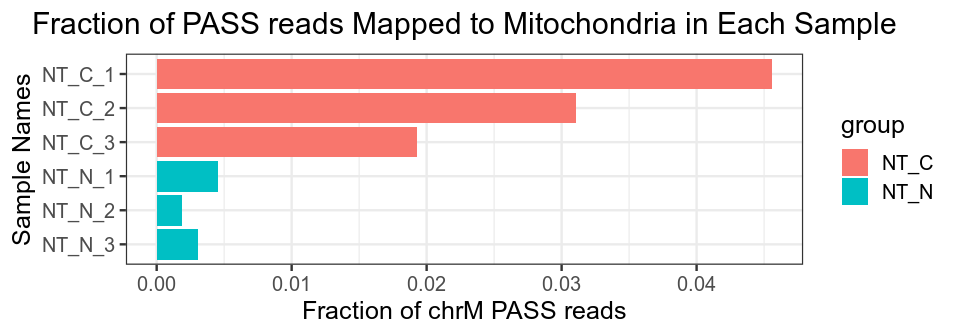

In [200]:
# Change plot size 
options(repr.plot.width=8, repr.plot.height=0.3*nrow(df)+1)

p

            .y. group1 group2         p p.adj p.format p.signif method
1 chrM_fraction   NT_C   NT_N 0.0616387 0.062    0.062       ns T-test


pdf 
  4

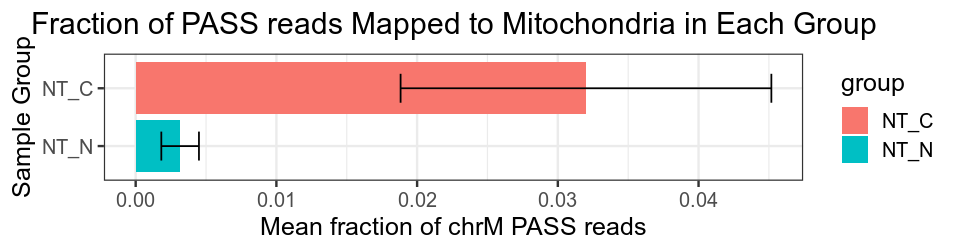

In [201]:
# Calculate mean and sd of chrM fractions
if(length(batches) > 1){
  sum_df = df %>%
    group_by(group) %>%
    summarise(chrM_mean_fraction = mean(chrM_fraction), 
              chrM_fraction_sd = sd(chrM_fraction)) %>%
    ungroup()
  
  p = ggplot(sum_df, aes(x = group, y = chrM_mean_fraction, fill = group)) +
    geom_col() +
    geom_errorbar(aes(x = group, 
                      ymin = chrM_mean_fraction-chrM_fraction_sd, 
                      ymax = chrM_mean_fraction+chrM_fraction_sd), 
                  width = 0.5) + 
#     stat_compare_means() +
    coord_flip() +
    scale_x_discrete(limits = rev(sum_df$group)) +
    xlab("Sample Group") +
    ylab("Mean fraction of chrM PASS reads") +
    ggtitle("Fraction of PASS reads Mapped to Mitochondria in Each Group")
  
  print(as.data.frame(compare_means(chrM_fraction~group, data=df, method="t.test")))
    
  options(repr.plot.width=8, repr.plot.height=0.3*(length(unique(sum_df$group)))+1.5)
  print(p)
  
}


if(length(batches) > 1){
  png(file.path(result_dir, "mean_chrM_reads_fraction.png"), 100*nrow(sum_df), 500)
  print(p)
  dev.off()
}

Set the "region" of intergenic pAs mapped to the mitochondria genome to "chrM":

In [202]:
pA[pA$region == "intergenic" & seqnames(pA) == "chrM"]$region = "chrM"

## 8. Resolve pA sites mapped to multiple genomic features of the same gene
pA sites can be mapped to multiple genomic features of the same gene due to alternative splicing. By default, the region annotation is simplified unless specified otherwise.

In [203]:
# Fix pAs mapped to multiple features
if(!exists("simplify_region_annotation") || simplify_region_annotation){
  pA$region[grepl("\\|intron$", pA$region)] = "intron"
  pA$region[grepl("\\|CDS$", pA$region)] = "CDS"
  pA$region[grepl("\\|5UTR$", pA$region)] = "5UTR"
}

## 9. Plot summarised distribution of pA sites and reads in genomic features in each sample.
First, summarize pA sites and read numbers in each genomic features in each sample. pA sites with less than *min_count_* in the sample are omitted. The results are saved in an Excel file.

In [204]:
require(scales)
require(openxlsx)

min_count_ = 5 # Read count filter

df = mcols(pA)[, c("region", sample_names)]

# Collapse pAs mapped to multiple features
df$region[grepl("\\|intron$", df$region)] = "intron"
df$region[grepl("\\|CDS$", df$region)] = "CDS"
df$region[grepl("\\|5UTR$", df$region)] = "5UTR"

# Change region names so that they can be used as column names
df$region[df$region == "3UTR"] = "UTR3"
df$region[df$region == "5UTR"] = "UTR5"


# Initialize counting matrixes
region_summary = matrix(nrow = 0, ncol = length(names(table(df$region))))
colnames(region_summary) = names(table(df$region))

read_summary = matrix(ncol = 0, nrow = length(names(table(df$region))))
rownames(read_summary) = names(table(df$region))


# Go through each sample, filter out pAs with low read numbers, and summarize
for(sample_name in sample_names){
  df_ = df[, c("region", sample_name)]
  df_ = df_[df_[, sample_name] >= min_count_, ]
  
  # Summarize numbers of pA site
  region_summary = rbind(region_summary, table(df_$region))
  
  # Summarize read numbers 
  col = group_by(as.data.frame(df_), region) %>%
    summarize_at(vars(sample_name), sum)
  read_summary = cbind(read_summary, col[, sample_name])
  
}

# Add row names and reorder rows
rownames(region_summary) = sample_names
region_summary = region_summary[order(rownames(region_summary)),]
region_summary = t(region_summary)

# Write to Excel
wb = createWorkbook()
addWorksheet(wb, "pA_region_summary")
writeData(wb, sheet = 1, region_summary, rowNames = T)
addWorksheet(wb, "pA_read_summary")
writeData(wb, sheet = 2, read_summary, rowNames = T)
suppressWarnings(saveWorkbook(wb, 
                              file.path(result_dir, "pA_region_and_read_summary.xlsx"),
                              overwrite = TRUE))

Loading required package: scales
Loading required package: openxlsx
Note: zip::zip() is deprecated, please use zip::zipr() instead


Plot distribution of pA sites. The ggplotly() function from the plotly library converts static ggplot2 figures into interactive figures.

In [205]:
# Plotting
region_summary = as.data.frame(region_summary)
region_summary$region = rownames(region_summary)
region_summary = gather(region_summary, key=Sample, value=num_pA, -region)
region_summary$region = factor(region_summary$region, 
                               levels = c("intergenic", "chrM", "ncRNA", "UA", 
                                          "UTR5", "CDS", "intron", "UTR3"))
region_summary$Sample = factor(region_summary$Sample)
p = ggplot(data=region_summary, aes(x=Sample, y=num_pA, fill = region)) + 
  geom_col(position = "fill") + 
  scale_y_continuous(labels = percent_format()) +
  scale_x_discrete(limits = rev(levels(region_summary$Sample))) +
  ylab("Percentage of pA sites") +
  coord_flip() +
  ggtitle("Percentage of pA Sites in Each Sample")

png(file.path(result_dir, "num_pA_summary.png"), 800, length(sample_names)*50)
print(p)
dev.off()

# ggplotly(p) # Uncomment this if you want to see interactive plots.

pdf 
  4

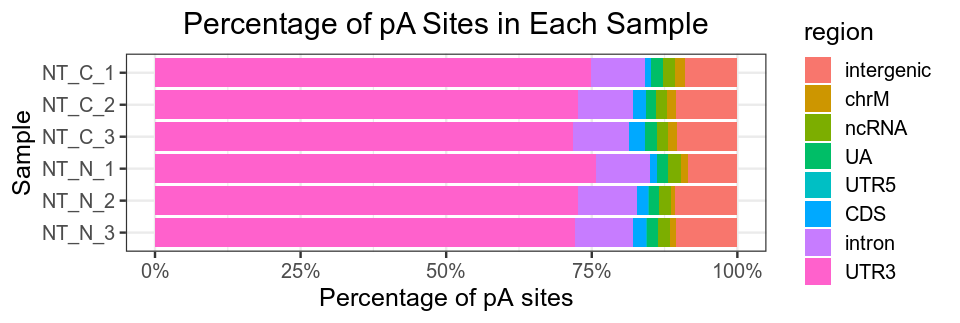

In [206]:
# Change plot size 
library(repr)
options(repr.plot.width=8, repr.plot.height=(length(sample_names)+3)*0.3)
p

Plot distribution of PASS reads. The ggplotly() function from the plotly library converts static ggplot2 figures into interactive figures.

In [207]:
read_summary = as.data.frame(read_summary)
read_summary$region = rownames(read_summary)
read_summary = gather(read_summary, key=Sample, value=num_read, -region)
read_summary$region = factor(read_summary$region, 
                             levels = c("intergenic", "chrM", "ncRNA", "UA",
                                        "UTR5", "CDS", "intron", "UTR3"))
region_summary$Sample = factor(region_summary$Sample)

p = ggplot(data=read_summary, aes(x=Sample, y=num_read, fill = region)) + 
  geom_col(position = "fill") + 
  scale_y_continuous(labels = percent_format()) +
  scale_x_discrete(limits = rev(levels(region_summary$Sample))) +
  ylab("Percentage of PASS reads") +
  coord_flip() +
  ggtitle("Percentage of PASS reads in Each Sample")

png(file.path(result_dir, "num_read_summary.png"), 800, length(sample_names)*50)
print(p)
dev.off()

# ggplotly(p) # Uncomment this if you want to see interactive plots.

pdf 
  4

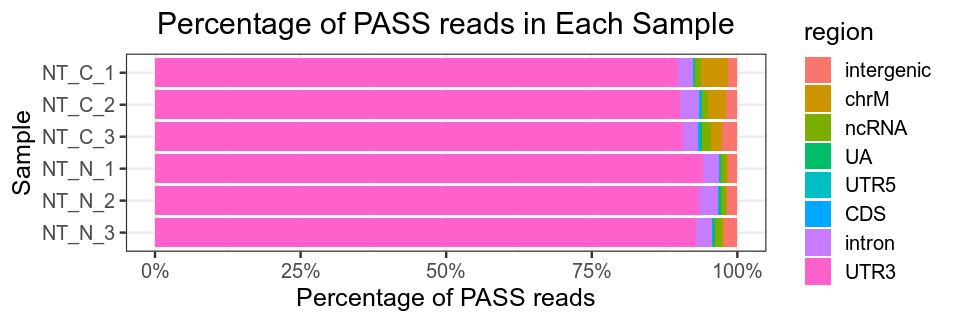

In [208]:
p

## 10. Plot nucleotide profile near pA sites

In [209]:
plot_nucleotide_profile = function(pA, 
                                   BSgeno = "BSgenome.Hsapiens.UCSC.hg19", 
                                   window_size = 100){
         #` A function for plotting nucleotide profile near pAs                                                
         require(GenomicRanges)                                                             
         require(BSgeno, character.only = T)                                                
         require(tidyr)                                                                     
         require(dplyr)                                                                     
         require(ggplot2)                                                                   
                                                                                            
         # Get genomic sequences                                                            
         seq = getSeq(eval(parse(text=BSgeno)), pA + window_size)                           
                                                                                            
         # Remove sequences with "N"                                                        
         seq = seq[!grepl("N", seq)]                                                        
                                                                                            
         # Computes the consensus matrix of a set of sequences                              
         m = consensusMatrix(seq)[1:4,]                                                     
                                                                                            
         # Normalization                                                                    
         m = scale(m, center = F, scale = colSums(m))                                       
                                                                                            
         # Column names indicates position relative to pA                                   
         colnames(m) = -window_size:window_size                                             
                                                                                            
         df = as.data.frame(t(m))                                                           
         df$Position = as.numeric(rownames(df))                                             
         
         p = df %>%                                                                         
           gather(key="Base", value = "Fraction", -Position) %>%                            
           ggplot(aes(x=Position, y=Fraction, color=Base)) +                                
           geom_line() +
           xlab("Position Relative to pA Site")
                                                                                    
         p                                                                                  
  }

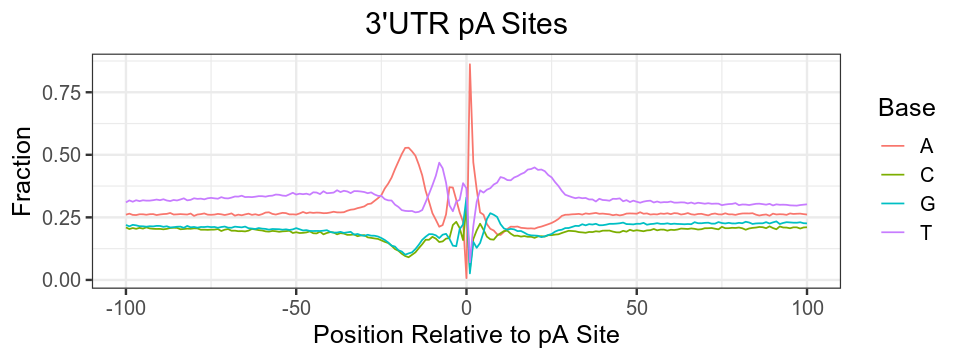

In [210]:
options(repr.plot.width=8, repr.plot.height=3)
plot_nucleotide_profile(pA[pA$region == "3UTR"], BSgeno) + ggtitle("3'UTR pA Sites")

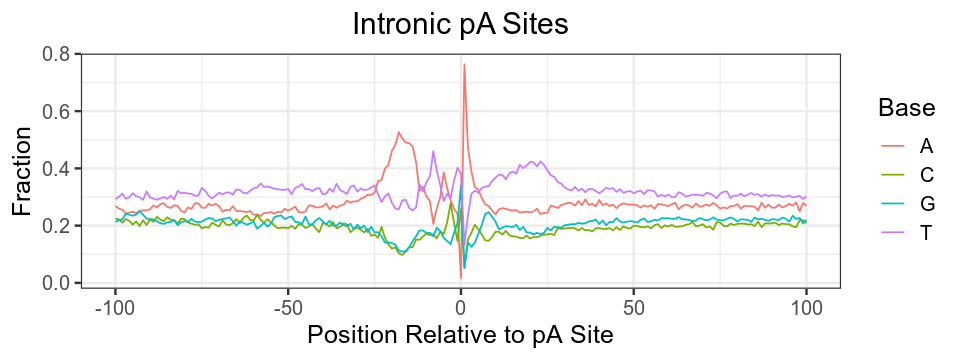

In [211]:
plot_nucleotide_profile(pA[pA$region == "intron"], BSgeno) + ggtitle("Intronic pA Sites")

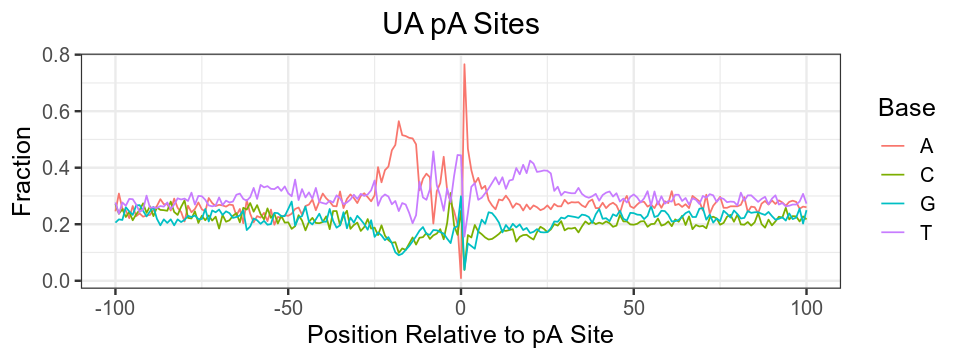

In [212]:
plot_nucleotide_profile(pA[pA$region == "UA"], BSgeno) + ggtitle("UA pA Sites")

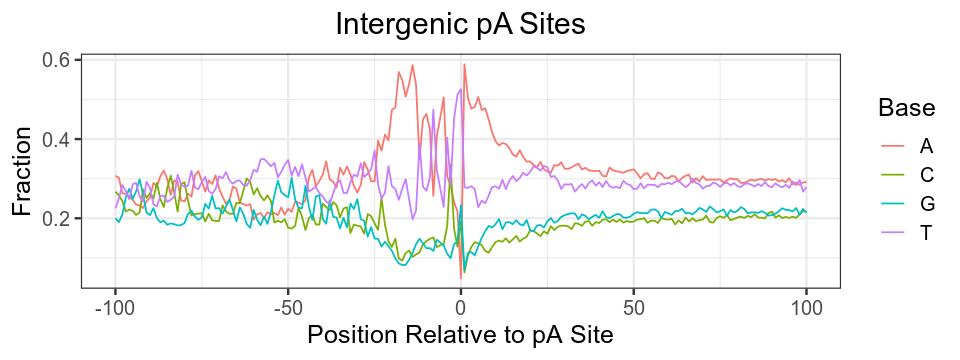

In [213]:
plot_nucleotide_profile(pA[pA$region == "intergenic"], BSgeno) + ggtitle("Intergenic pA Sites")

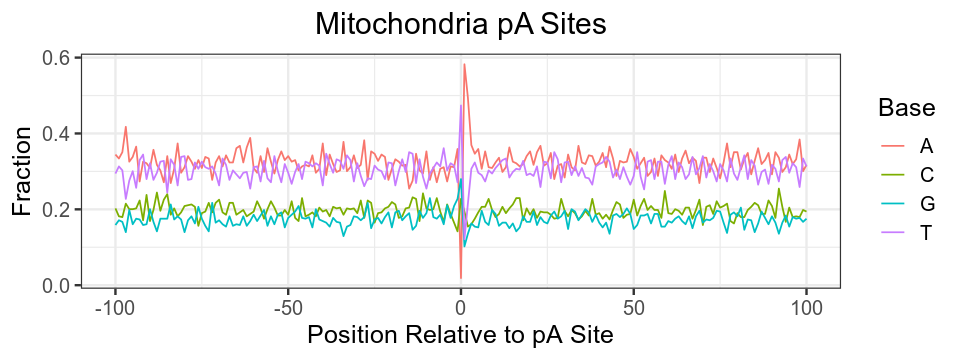

In [214]:
plot_nucleotide_profile(pA[pA$region == "chrM"], BSgeno) + ggtitle("Mitochondria pA Sites")

From the above plots, **we can see that 3'UTR, intronic, and UA pA sites have similar nucleotide profiles around the pA sites, while intergenice and mitochondria pA sites have nucleotide profiles different from regular pA sites.**

# 11. Calculate optimal transcript starting sites (TSSs) 
For genes with >1 UA pA sites and >1 TSSs, use the TSS closest to the most downstream UA pA site, otherwise only keep the most upstream TSS.

In [215]:
# Get TSS 
tss = promoters(txdb, upstream=0, downstream=1, columns=c("tx_name", "gene_id"))

# Convert the accession numbers of the genes into gene symbols
tss$gene_symbol = mapIds(org.db, keys = as.character(tss$tx_name),
                         keytype =  "ACCNUM", column =  "SYMBOL")

# Only consider detected genes
tss = tss[tss$gene_symbol %in% pA$gene_symbol]

# Remove duplicates (One gene can have multiple transcripts with the same TSS)
tss = data.frame(chr = seqnames(tss), strand = strand(tss), 
                 position = start(tss), gene_symbol = tss$gene_symbol)
tss = unique(tss)
tss$gene_symbol = as.vector(tss$gene_symbol)

# Calculate signed position for later use 
pA$signed_position = start(pA) * ifelse(strand(pA) == "+", 1, -1)
tss$signed_position = tss$position * ifelse(tss$strand == "+", 1, -1) 

# Split tss into two categories and treat them differently
tss_with_ua = tss[tss$gene_symbol %in% pA[pA$region == "UA"]$gene_symbol, ]
tss_without_ua = tss[!tss$gene_symbol %in% pA[pA$region == "UA"]$gene_symbol, ]

# Loop through genes in tss_with_ua, select the most reasonable TSS for each gene
tss_with_ua_new = data.frame()
for(gene in unique(tss_with_ua$gene_symbol)){
  tss_for_gene = subset(tss_with_ua, gene_symbol == gene)
  if(nrow(tss_for_gene) == 1){
    tss_with_ua_new = rbind(tss_with_ua_new, tss_for_gene)
  }else{
    # Determine the most reasonable UA pA sites: 
    # pick the UA pA sites upstream to all other UA pA sites
    ua_pA = pA[pA$gene_symbol == gene & pA$region == "UA"] # may have >1 rows
    # ua_pA$signed_position is negative if the gene is on positive strand!
    ua_pA = ua_pA[order(ua_pA$signed_position), ][1,] 
    # tss must be down stream of UA pA site 
    tss_for_gene = tss_for_gene[-ua_pA$signed_position - tss_for_gene$signed_position < 0,]
    # Select the tss closest to the UA pA site
    tss_for_gene = tss_for_gene[which.max(-ua_pA$signed_position - 
                                          tss_for_gene$signed_position),]
    tss_with_ua_new = rbind(tss_with_ua_new, tss_for_gene)
  }
}

# For tss without detected ua pA sites, simply pick the most upstream one
tss_without_ua = tss_without_ua[order(tss_without_ua$gene_symbol, 
                                      tss_without_ua$signed_position), ]
tss_without_ua = split(tss_without_ua, f=tss_without_ua$gene_symbol)
tss_without_ua = do.call(rbind, lapply(tss_without_ua, function(x) x[1,]))
                                       
# Combine the two data frame
tss = rbind(tss_with_ua_new, tss_without_ua)
df = data.frame(gene_symbol = as.vector(pA$gene_symbol))
                                       
# Unmatched rows will be put at the end of the merged table
df = merge(df, tss, by = "gene_symbol", all.x=T, sort=F)
                                       
# Cannot assume that the order remain the same even after setting sort = F
pA = pA[order(pA$gene_symbol)] 
df = df[order(df$gene_symbol),]
pA$tss_position = df$position

rm(tss)
rm(df)

'select()' returned 1:1 mapping between keys and columns


## 12.1. Calculate CDS features for the transcript with the longest CDS for each gene
Due to alternative splicing, some genes can have multiple transcripts with different CDS. This step will find the transcript with longest CDS. If there are ties, the transcript will be selected randomly.

In [216]:
# Calculate CDS features of the transcript with maximum CDS length for each gene
cds = suppressWarnings(cdsBy(txdb, by="tx", use.names=T))

# Calculate total CDS length for each transcript
cds_length = foreach(i=1:length(cds), .combine = "c") %dopar%{
  sum(width(cds[i]))
}

# Split by gene symbols
cds_length = split(cds_length, mapIds(org.db, keys = names(cds_length), 
                                      keytype =  "ACCNUM", column =  "SYMBOL"))

# Get transcripts with longest CDS
max_cds_tx_name = names(sapply(cds_length, which.max))
max_cds_tx_name = sub("^.+\\.", "", max_cds_tx_name) 

# Get CDS sequence
maxCDS_seq = getSeq(eval(parse(text = BSspec)), cds[max_cds_tx_name])
maxCDS_seq = lapply(maxCDS_seq, function(x) unlist(x))
maxCDS_seq = DNAStringSet(maxCDS_seq)
                    
# Calculate base frequency
base_fraction = alphabetFrequency(maxCDS_seq, baseOnly=T, as.prob=T)
                    
CDS_features = data.frame(maxCDS_tx = names(maxCDS_seq), 
                          cds_start = unlist(start(range(cds[max_cds_tx_name]))),
                          cds_end = unlist(end(range(cds[max_cds_tx_name]))),
                          CDS_size = width(maxCDS_seq), 
                          CDS_GC = base_fraction[, "C"] + base_fraction[, "G"],
                          stringsAsFactors = F)
                    
CDS_features$gene_symbol =  mapIds(org.db, keys = CDS_features$maxCDS_tx, 
                                   keytype =  "ACCNUM", column =  "SYMBOL")
                    
                    
rm(cds, maxCDS_seq, max_cds_tx_name, cds_length)

'select()' returned 1:1 mapping between keys and columns
'select()' returned 1:1 mapping between keys and columns


## 12.2. Calculate intron features for the transcript with longest CDS of each gene

In [217]:
# Calculate features of introns of the longest CDS transcript
introns = suppressWarnings(intronsByTranscript(txdb, use.names=T))

introns = introns[names(introns) %in% CDS_features$maxCDS_tx]

intron_sizes = lapply(introns, function(intron) width(intron))
                      
# Remove NULL or 0-length introns                      
mask = sapply(intron_sizes, function(intron) length(intron) > 0)
introns = introns[mask]
intron_sizes = intron_sizes[mask]

intron_features = data.frame(maxCDS_tx = as.character(names(introns)), 
                             max_intron_size = sapply(intron_sizes, max), 
                             min_intron_size = sapply(intron_sizes, min),
                             total_intron_size = sapply(intron_sizes, sum),
                             num_intron = sapply(intron_sizes, function(sizes) sum(sizes > 0)),
                             stringsAsFactors = F)
                                                 
intron_features[intron_features %in% c(Inf, -Inf)] = 0
                             
rm(introns, intron_sizes, mask)

## 12.3. Calculate 5'UTR features for the transcript with longest CDS of each gene

In [221]:
# Calculation features of 5'UTRs of the longest CDS transcript
UTR5 = suppressWarnings(fiveUTRsByTranscript(txdb, use.names=T))
UTR5 = UTR5[names(UTR5) %in% CDS_features$maxCDS_tx]

UTR5_seq = getSeq(eval(parse(text = BSspec)), UTR5)
UTR5_seq = lapply(UTR5_seq, function(x) unlist(x))
UTR5_seq = DNAStringSet(UTR5_seq)
                  
base_fraction = alphabetFrequency(UTR5_seq, baseOnly=T, as.prob=T)

UTR5_features = data.frame(maxCDS_tx = names(UTR5), 
                           UTR5_size = sapply(UTR5, function(UTR5) sum(width(UTR5))), 
                           UTR5_GC = base_fraction[, "C"] + base_fraction[, "G"],
                           stringsAsFactors = F)

Predict uORFs in 5'UTRs:

In [222]:
# Predict uORF in 5'UTRs
orf_count = data.frame(gene_symbol = names(UTR5_seq), uORF = 0)

for(gene in names(UTR5_seq)){
  orf = findORFsinSeq(unlist(UTR5_seq[[gene]]))
  if(sum(orf[["lengths"]] > 30, na.rm = T)){
    orf_count[orf_count$gene_symbol == gene, "uORF"] = sum(orf[["lengths"]] > 30)
  }
}

uORF = orf_count$uORF
names(uORF) = orf_count$gene_symbol

pA$uORF = uORF[pA$gene_symbol]
rm(UTR5_seq, UTR5)

## 12.4. Calculate non-coding RNA (ncRNA) features
*ncTx* was created in Step 5 when mapping pAs to non-coding RNAs.

In [223]:
# Get exonic sequence
ncRNA_seq = getSeq(eval(parse(text=BSgeno)), ncTx)

ncRNA_seq = lapply(ncRNA_seq, function(x) unlist(x))
                   
ncRNA_seq = DNAStringSet(ncRNA_seq)
                   
# Calculate GC content
base_fraction = alphabetFrequency(ncRNA_seq, baseOnly=T, as.prob=T)
ncRNA_features = data.frame(gene_symbol = names(ncRNA_seq), 
                            ncRNA_size = width(ncRNA_seq), 
                            ncRNA_GC = base_fraction[, "C"] + base_fraction[, "G"],
                            stringsAsFactors = F)

rm(ncRNA_seq)

## 12.5. Combine 5'UTR, CDS, intron, and ncRNA features with pA sites in a dataframe
The *pas* dataframe will be mentioned a lot in downstream analysis. **pas** means **p**oly**a**denylation **s**ites. 

In [224]:
# Conver the GRanges into a dataframe for further calculation
pas = cbind(data.frame(chr = seqnames(pA), strand = strand(pA), pA_pos = start(pA)), 
              data.frame(mcols(pA)))
pas$pAid = with(pas, paste0(chr, strand, pA_pos))

utr3 = pas %>%
  dplyr::filter(region == "3UTR") %>%
  left_join(CDS_features, by = "gene_symbol") %>%
  left_join(UTR5_features, by = "maxCDS_tx") %>%
  left_join(intron_features, by = "maxCDS_tx") 

other = pas %>%
  dplyr::filter(region != "3UTR") %>%
  left_join(ncRNA_features, by = "gene_symbol")
  
pas = bind_rows(utr3, other) %>% 
      # Delete a few (4) rows with duplicated pAid
      dplyr::filter(!pAid %in% pAid[duplicated(pAid)])

rm(CDS_features, intron_features, UTR5_features, ncRNA_features)

## 12.6. Calculate exonic 3'UTR sequence, GC content, and size
Some 3'UTRs contain introns. To get only exonic 3'UTR sequences, I first get genomic sequences between CDS ends and the pA sites for all the pA sites, then update sequences for 3'UTRs containing introns that do not overlap with any annotated 3'UTRs.

In [225]:
geno = eval(parse(text = BSspec))

# Create 3'UTR GRanges for pAs mapped to 3'UTRs, introns included      
pA_3UTR = create_3UTRs_from_pAs(pas) 

# Get genomic sequence for the 3'UTRs, without removing intronic sequences
pA_3UTR$exonic_3UTR_seq = as.character(getSeq(geno, pA_3UTR))

# Remove introns mapped to >1 strands
introns = suppressWarnings(intronsByTranscript(txdb, use.names=T))
introns = rename_grl(introns, old_key = "ACCNUM", new_key = "SYMBOL")
introns = unlist(introns)

# Remove 3pUTRs mapped to >1 strands
threeUTRs = suppressWarnings(threeUTRsByTranscript(txdb, use.names=T))
threeUTRs = rename_grl(threeUTRs, old_key = "ACCNUM", new_key = "SYMBOL")
threeUTRs = unlist(threeUTRs)

rm(txdb)

# Only keep intronic regions not overlapping with any annotated 3'UTRs
introns = setdiff(introns, threeUTRs)

# Make a list to work on individual 3'UTR containing introns
pA_3UTR_lst = split(pA_3UTR, pA_3UTR$pAid)
olp = findOverlaps(introns, pA_3UTR_lst, type = "within")

# Record which 3'UTRs contain introns
pA_3UTR$has_intron = F
pA_3UTR[subjectHits(olp), ]$has_intron = T

# Remove intron from each 3'UTR, then get genomic sequence
pA_3UTR[subjectHits(olp), ]$exonic_3UTR_seq = sapply(1:length(olp), function(i) {
  gr = setdiff(pA_3UTR_lst[[subjectHits(olp[i])]], introns[queryHits(olp[i])])   
  as.character(unlist(getSeq(geno, gr)))
  }
)

# Report how many introns have been removed from how many 3'UTRs
cat(length(unique(queryHits(olp))), "introns were removed from", 
    length(unique(subjectHits(olp))), "3'UTRs.")

# Calculate 3'UTR GC content
utr3_seq = DNAStringSet(pA_3UTR$exonic_3UTR_seq)
base_fraction = alphabetFrequency(utr3_seq, baseOnly=T, as.prob=T)
pA_3UTR$UTR3_GC = base_fraction[, "C"] + base_fraction[, "G"]
pA_3UTR$UTR3_size = width(utr3_seq)

# Add the 3'UTR features to pas data frame
pas = merge(pas, 
            as.data.frame(mcols(pA_3UTR)[, c("pAid", "exonic_3UTR_seq", 
                                             "UTR3_GC", "UTR3_size", "has_intron")]), 
            all.x=T, sort=F)

# Calculate transcript size for mRNA and ncRNA
pas$tx_size = rowSums(pas[, c("UTR5_size", "CDS_size", "UTR3_size")])

pas[pas$region == "ncRNA", ]$tx_size = pas[pas$region == "ncRNA", ]$ncRNA_size 

# Calculate transcript GC content
pas$tx_GC = with(pas, (UTR5_size*UTR5_GC + CDS_size*CDS_GC + UTR3_size*UTR3_GC)/
                      (UTR5_size + CDS_size + UTR3_size))
# pas$partial_tx_GC = with(pas, (CDS_size*CDS_GC + UTR3_size*UTR3_GC)/
#                               (CDS_size + UTR3_size))
pas[pas$region == "ncRNA", ]$tx_GC = pas[pas$region == "ncRNA", ]$ncRNA_GC 

'select()' returned 1:1 mapping between keys and columns
'select()' returned 1:1 mapping between keys and columns


522 introns were removed from 1054 3'UTRs.

## 12.7 Check correlations among 5'UTR, CDS, and 3'UTR GC content
I divided transcripts into 3 groups based on their CDS sizes and then I checked if 5'UTR, CDS, and 3'UTR GC content for the transcripts are correlated.

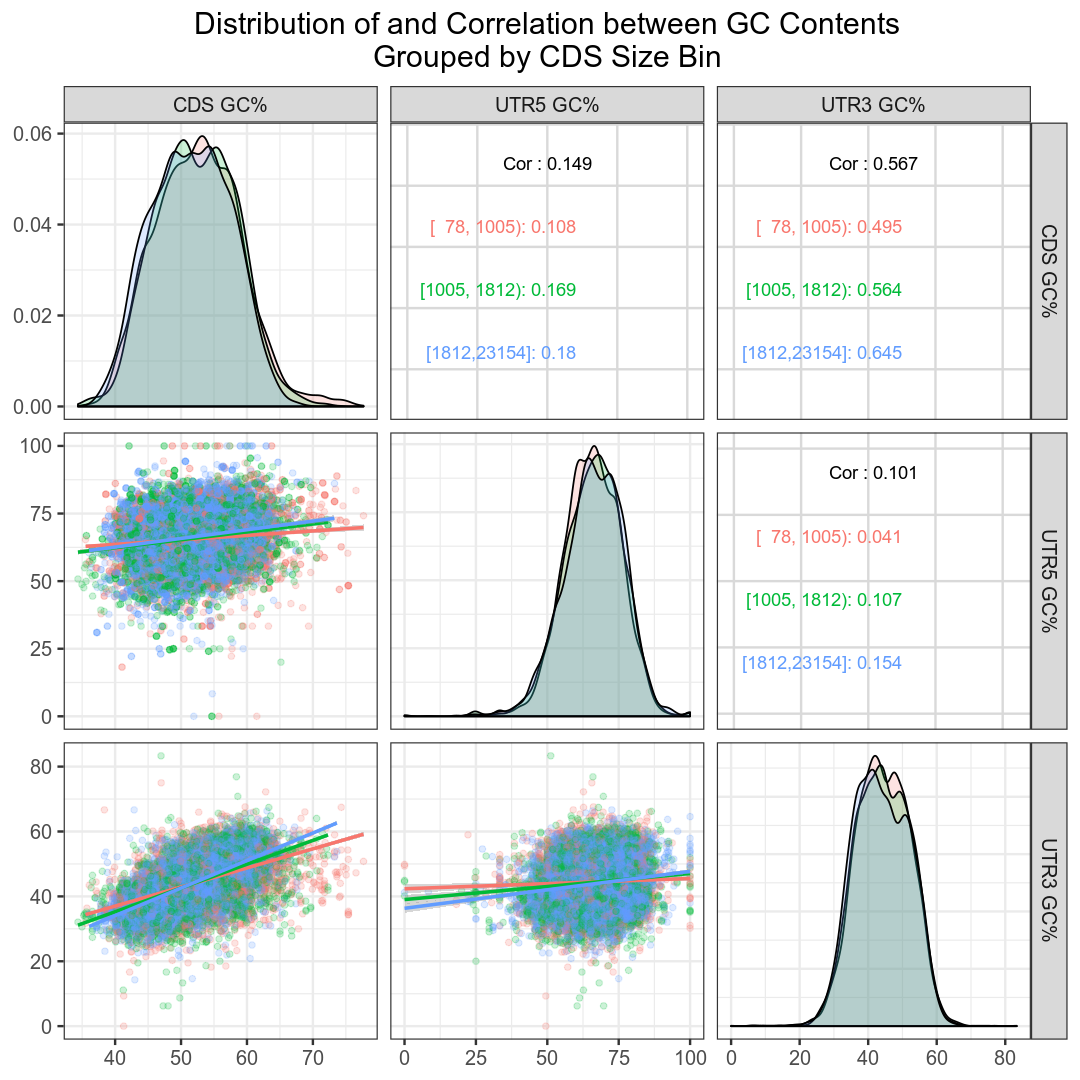

In [13]:
options(repr.plot.width=9, repr.plot.height=9)
oldw = getOption("warn")
options(warn = -1)

df = pas[, grep("^[^n][^c].+_GC|CDS_size", names(pas))] %>%
  distinct() %>%
  mutate(CDS_size = Hmisc::cut2(CDS_size, g=3)) %>%
  mutate_at(vars(matches("_GC")), list(~.*100))

names(df) = sub("_GC", " GC%", names(df))

require(GGally)
ggpairs(df, columns = grep("GC", names(df)),
        ggplot2::aes(color=CDS_size),
        lower = list(continuous = wrap("smooth", alpha = 0.2)),
        diag = list(continuous = wrap("densityDiag", alpha = 0.2)),
        title = "Distribution of and Correlation between GC Contents\nGrouped by CDS Size Bin")


options(warn=oldw)

From the above plot we can see that **while CDS GC% and 3'UTR GC% are quite strongly correlated, 5'UTR GC% is almost not correlated with CDS GC% or 3'UTR GC%. Moreover, the correlation patterns are the same for transcripts with different CDS sizes.**

## 13. Identify subtypes of pA sites.
Just to follow conventions, 3'UTR pA sites are further classified into "S" (Single), "F" (First), "M" (Middle), and "L" (Last) subtypes. 5'UTR and CDS pA sites are combined into "E" type. 

In [227]:
# Distance between pA site and TSS
pas$distance_to_tss = abs(pas$pA_pos - pas$tss_position)
pas$distance_to_tss = ifelse(pas$region == "UA", -1*pas$distance_to_tss, pas$distance_to_tss)

# Calculate pA_type
pas$pA_type = ifelse(grepl("intron", pas$region), "I", 
                       ifelse(grepl("CDS|5UTR", pas$region), "E", 
                              ifelse(pas$region == "UA", "UA",
                                     ifelse(pas$region == "chrM", "chrM",
                                            ifelse(pas$region == "intergenic", "Intergenic",
                                                   "SFML"))))) # ncRNA may also have SFML types

pas$pA_type[table(pas$gene_symbol)[pas$gene_symbol] == 1 & pas$pA_type == "SFML"] = "S"

tmp = dplyr::filter(as.data.frame(pas), pA_type == "SFML") %>%
  group_by(gene_symbol) %>%
  mutate(percrank=percent_rank(distance_to_tss))

tmp$pA_type = ifelse(tmp$percrank == 0, "F", 
                     ifelse(tmp$percrank == 1, "L", "M"))

pas = rbind(pas[pas$pA_type != "SFML",], as.data.frame(tmp[, -grep("percrank", names(tmp))]))

pas = as.data.frame(pas) %>% 
      group_by(gene_symbol) %>%
      arrange(distance_to_tss)

pas = as.data.frame(pas)

rm(tmp)

## 14. Calculate poly(A) signal (PAS) using the 40 nt sequence upstream of pA sites

In [228]:
# Calculate PAS using the 40 nt sequence upstream of pA
motifcounts = countAllMotif(pas, geno = GENOME, search_from = 0, 
                            search_len = 40, motif_width = 6)

PASs = c("AATAAA", "ATTAAA", "AGTAAA", "TATAAA", "CATAAA", "GATAAA", "AATATA", "AATACA", 
         "AATAGA", "AAAAAG", "ACTAAA", "AAAAAA")

motifcounts = motifcounts[, PASs]

PAScounts = cbind(motifcounts[, PASs[1:2]], 
                  OtherPAS = rowSums(motifcounts[, PASs[3:(length(PASs) -1)]]),
                  Arich = motifcounts[, "AAAAAA"])

PAScounts = as.data.frame(PAScounts)

pas$PAS = ifelse(PAScounts$AATAAA > 0, "AATAAA", 
                   ifelse(PAScounts$ATTAAA > 0, "ATTAAA",
                          ifelse(PAScounts$OtherPAS > 0, "OtherPAS",
                                 ifelse(PAScounts$Arich > 0, "Arich", "NoPAS"))))
rm(motifcounts)
rm(PAScounts)

## 15. Check if different subtypes of pA sites tend to use different PAS (poly(A) signal)

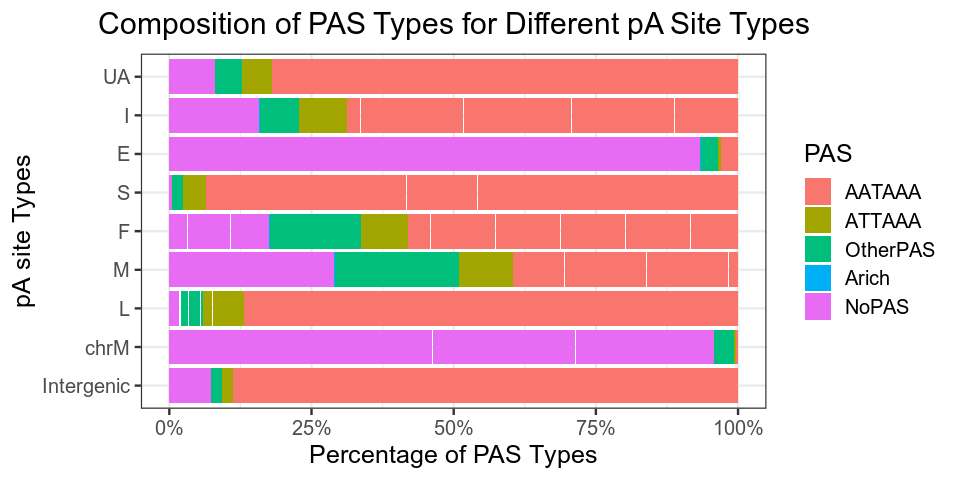

In [229]:
options(repr.plot.width=8, repr.plot.height=4)

pas %>% 
  dplyr::select(pA_type, PAS) %>%
  drop_na() %>% 
  group_by(pA_type, PAS) %>%
  mutate(count = n()) %>%
  ungroup() %>%
  mutate(pA_type = factor(pA_type, levels = rev(c("UA", "I", 'E', "S", "F", "M", "L",  
                                                  "ncRNA", "chrM", "Intergenic")))) %>%
  mutate(PAS = factor(PAS, levels = c("AATAAA", "ATTAAA", "OtherPAS", "Arich", "NoPAS"))) %>%
  ggplot(aes(x = pA_type, y = count, fill = PAS)) +
  geom_col(position = "fill") + 
  scale_y_continuous(labels = percent_format()) +
  ylab("Percentage of PAS Types") +
  xlab("pA site Types") +
  ggtitle("Composition of PAS Types for Different pA Site Types") +
  coord_flip() 

From the above plot, it seems that **pA sites mapped to mitochondria (chrM) and CDS or 5'UTRs (E) tend to have no obvious PAS. On the other hand, UA and intergenic pA sites also have PAS similar to 3'UTR pA sites (especially S (single pA site per gene) and L (last 3'UTR pA sites in APA 3'UTRs)). Compared with L pA sites, F (first pA sites in APA 3'UTRs) and M (middle pA sites in APA 3'UTRs) sites tend to have more weaker PAS.**

## 16. Add gene description and gene id

In [230]:
# Add gene_symbol and gene_id using org.x.db
pas$gene_id = as.numeric(mapIds(org.db, keys = pas$gene_symbol, 
                                keytype =  "SYMBOL", column =  "ENTREZID"))

pas$description = mapIds(org.db, keys = pas$gene_symbol, 
                         keytype = "SYMBOL", column = "GENENAME")

'select()' returned 1:many mapping between keys and columns
'select()' returned 1:1 mapping between keys and columns


## 17.1. Calculate RPM (Reads Per Million) for each pA site
To reduce the effect of extreme values when calculating RPM, only sum up read numbers between 0.5 and 0.95 quantile. UA reads and intergenic reads will not be included when calculating total reads numbers.

In [231]:
# Calculate RPM, using total reads 
for(sample_name in sample_names){
  # only use genic reads
  all_counts = pas[pas$gene_symbol != "Unknown", sample_name] 
  # between 0.5 and 0.95 quantile
  range = quantile(all_counts, c(0.05, 0.95))
  trimmed_counts = all_counts[all_counts >= range[1] & all_counts <= range[2]]
    
  pas[,paste0(sample_name, "_rpm")] = 10^6*pas[,sample_name]/sum(trimmed_counts)
}

## 17.2. Total read number per gene, without including reads from UA pA sites

In [232]:
# Calculate total reads number per gene, without counting pAs in UA 
num_per_gene = aggregate(pas[pas$region != "UA" & pas$region != "intergenic", sample_names], 
                         list(gene_symbol = pas[pas$region != "UA" & 
                                                pas$region != "intergenic",]$gene_symbol
                             ), 
                         sum)

names(num_per_gene)[-1] = paste0(names(num_per_gene)[-1], "_gene")

pas = merge(pas, num_per_gene, all.x = T, sort = F)

rm(num_per_gene)

## 17.3. pA site usage (fraction of PASS reads from each pA site among all pA sites of the same gene)

In [233]:
# Calculate pA usage
for(sample_name in sample_names){
  pas[, paste0(sample_name, "_usage")] = 0
    
  pas[pas$region != "UA", paste0(sample_name, "_usage")] = 
      pas[pas$region != "UA", sample_name]*100/
      pas[pas$region != "UA", paste0(sample_name, "_gene")]
}

## 17.4. Total 3'UTR reads and 3'UTR RPMs per gene
Since only transcripts with 3'UTR pA sites can encode the full length protein, total 3'UTR reads can be used to measure gene expression.

In [234]:
#### Calculate total 3'UTR reads per gene
num_in_3utr_per_gene = aggregate(pas[pas$region == "3UTR", sample_names], 
                                 list(gene_symbol= pas[pas$region == "3UTR",]$gene_symbol),
                                 sum)

names(num_in_3utr_per_gene)[-1] = paste0(names(num_in_3utr_per_gene)[-1], "_3utr")

pas = merge(pas, num_in_3utr_per_gene, all.x=T, sort = F)

rm(num_in_3utr_per_gene)

In [235]:
# Calculate total 3'UTR RPMs per gene
rpm_in_3utr_per_gene = aggregate(pas[pas$region == "3UTR", paste0(sample_names, "_rpm")], 
                                 list(gene_symbol= pas[pas$region == "3UTR",]$gene_symbol),
                                 sum)

names(rpm_in_3utr_per_gene)[-1] = paste0(names(rpm_in_3utr_per_gene)[-1], "_3utr")

pas = merge(pas, rpm_in_3utr_per_gene, all.x=T, sort = F)

rm(rpm_in_3utr_per_gene)

# Change column names
colnames(pas) = sub("(_\\d+[a-z]?)$", "\\1_count", colnames(pas))

In [236]:
# Calculate genewise RPM
for(samplename in sample_names){
  all_counts = pas[, paste0(samplename, "_count")]
  range = quantile(all_counts, c(0.05, 0.95))
  trimmed_counts = all_counts[all_counts >= range[1] & all_counts <= range[2]]
  pas[, paste0("Gene_RPM_", samplename)] = 10^6 * pas[, paste0(samplename, "_gene")]/
                                                  sum(trimmed_counts)
}

## 18. Filter out lowly expressed 3'UTR pAs
For downstream analysis, it is necessary to focus on only significantly expressed transcripts. However, I also want to keep lowly expressed transcripts if the pA sites are not in 3'UTR, since they are generally unstable.

In [237]:
# Filter lowly expressed pAs
if(exists("filter_strength")){
  if(filter_strength < 0 | filter_strength > 1){
    stop("filter_strength must be between 0 and 1.")
  }
}else{
  # 0 ~ 1, bigger value means more stringent filtering
  filter_strength = 1/2 
}

filter1 = rowSums(pas[,grepl("_usage$", names(pas))] >= 
          lowest_usage, na.rm = T) >= length(sample_names)*filter_strength
filter2 = rowSums(pas[,grepl("_rpm$", names(pas))] >= lowest_rpm, na.rm = T) >= 
          length(sample_names)*filter_strength
filter3 = rowSums(pas[,grepl("_count$", names(pas))] >= lowest_count, na.rm = T) >= 
          length(sample_names)*filter_strength

# Keep pAs in other genic regions (outside of 3'UTRs)
filter4 = pas$region != "3UTR"
pas = pas[(filter1 & filter2 & filter3)|filter4, ]

## 19. Calculate number of pA sites per gene and its relationship with the GC% of 3'UTR and CDS.
This analysis is done after filtering out lowly expressed pA sites, so that the result is not affected by noise.

In [238]:
# Calculate number of pAs per gene
Num_pA = as.data.frame(table(pas$gene_symbol[pas$gene_symbol != "Unknown"]))

names(Num_pA) = c("gene_symbol", "Num_pA")

pas = merge(pas, Num_pA, by = "gene_symbol", all.x=T, sort=F)

rm(Num_pA)

The nucleotide profile near 3'UTR pA sites are AU-rich (shown in step 10), so I wondered if Genes with GC-rich 3'UTRs tend to have less pA sites:


Attaching package: ‘ggridges’

The following object is masked from ‘package:ggplot2’:

    scale_discrete_manual

Loading required package: viridisLite

Attaching package: ‘viridis’

The following object is masked from ‘package:scales’:

    viridis_pal

Picking joint bandwidth of 1.39


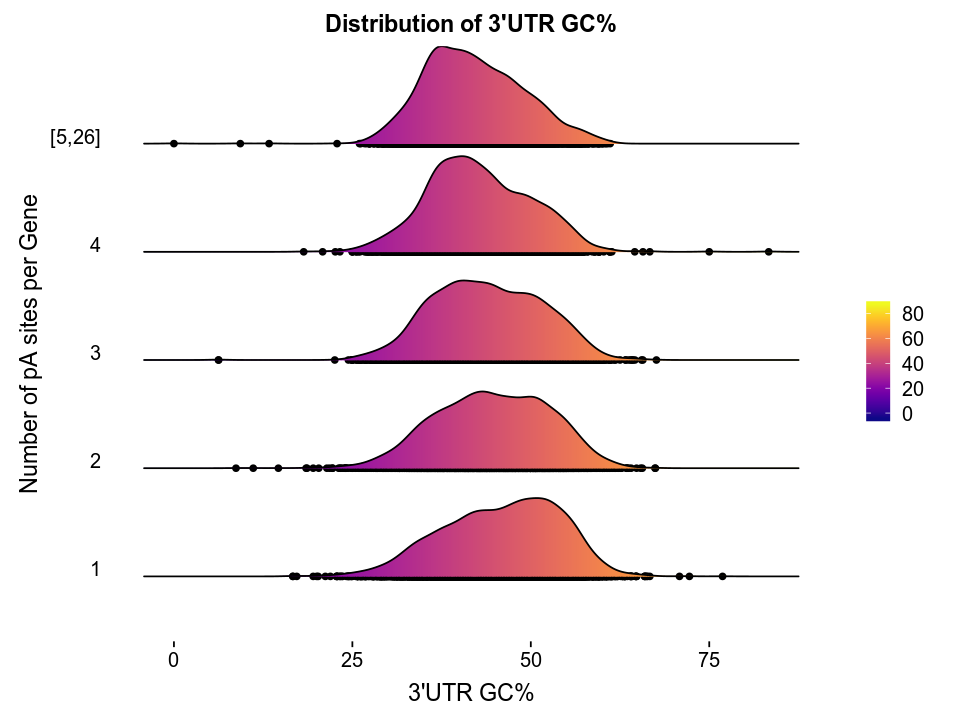

In [239]:
options(repr.plot.width=8, repr.plot.height=6)
library(ggridges)
library(viridis)

df = pas[, grep("^[^n][^c].+_GC|Num_pA", names(pas))] %>%
  distinct() %>%
  drop_na() %>%
  mutate(Num_pA = Hmisc::cut2(Num_pA, g = 5)) %>%
  mutate_at(vars(matches("_GC")), list(~.*100))

p = ggplot(df, aes(x=UTR3_GC, y=Num_pA, fill = ..x..)) +
  geom_point() +
  geom_density_ridges_gradient(scale = 0.9, gradient_lwd = 0.5, color = "black") +
  scale_fill_viridis(option = "plasma", name = "") +
  labs(x = "3'UTR GC%", y = "Number of pA sites per Gene") +
  theme_ridges(grid = F, center_axis_labels = T) +
  theme(plot.title = element_text(hjust = 0.5)) +
  ggtitle("Distribution of 3'UTR GC%")

p


Since the GC% in 3'UTRs and CDSs are correlated (Step 12.7), it is not surprising that genes with GC-rich CDS tend to have fewer poly(A) sites:

## 20. Calculate Minimum Folding Energy (MFE) of exonic 3'UTR sequences
I use a 100-nt sliding window (step size 50 nt) to calculate MFE of exonic 3'UTR sequences within the window. Then the min, median, max, and mean of the MFEs (from the sliding windows) were calcualted for each 3'UTR. 

If the 3'UTR is shorter than window_size (100 nt), the MFE will be NA. If the last sliding window is shorter than 100 nt (most cases), the window will be slided back to include the last nucleotide.

The functions for doing the calculation were written in python, because I need to use [ViennaRNA](https://www.tbi.univie.ac.at/RNA/ViennaRNA/doc/html/install.html), which only has python binding. Luckily, it is possible to import python functions into R using the *reticulate* library. 

The [Dask](https://dask.org/) library is used for parallel computing in the get_mfe() function.

In [241]:
library(reticulate)
use_condaenv("base")

# Source the python function get_mfe() from mfe.py
source_python(file.path(MODULE_DIR, "mfe.py"))

# Calculate MFE using 8 CPUs
pas = get_mfe(pas, seq_column="exonic_3UTR_seq", 
              num_workers=8L, window_size=100L, step_size=50L) # L: integer

write.csv(pas, file.path(result_dir, "pas.csv"), row.names=F)


Attaching package: ‘reticulate’

The following object is masked from ‘package:rtracklayer’:

    import



Confirm that minimal folding energy (MFE) is negatively correlated with 3'UTR GC%:

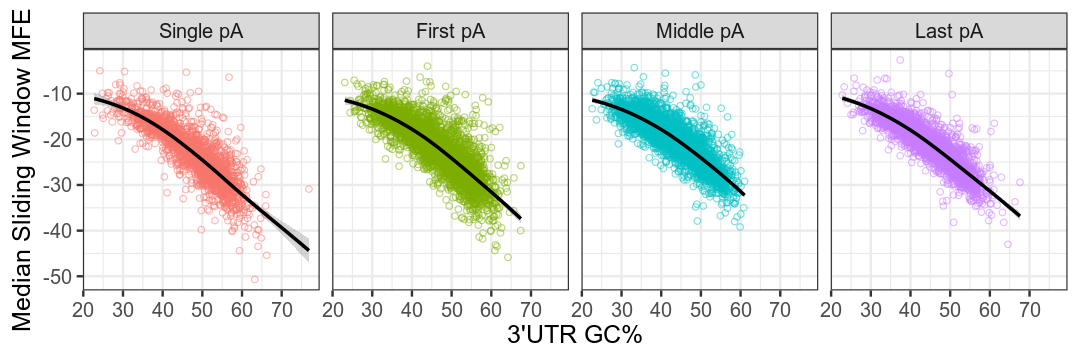

In [242]:
options(repr.plot.width=9, repr.plot.height=3)

p = pas %>%
  mutate(pA_type = sub("S", "Single pA", pA_type)) %>%
  mutate(pA_type = sub("F", "First pA", pA_type)) %>%
  mutate(pA_type = sub("M", "Middle pA", pA_type)) %>%
  mutate(pA_type = sub("L", "Last pA", pA_type)) %>%
  mutate(pA_type = factor(pA_type, levels=c("Single pA", "First pA", 
                                            "Middle pA", "Last pA"))) %>%
  mutate(UTR3_GC = 100*UTR3_GC) %>%
  dplyr::filter(!is.na(window_mfe_median)) %>%
  ggplot(aes(x=UTR3_GC, y=window_mfe_median, color=pA_type)) +
  geom_point(shape=1, alpha=0.5) +
  geom_smooth(method="loess", color="black", span=0.99) +
  theme(legend.position = "none") +
  facet_grid(~pA_type) +
  xlab("3'UTR GC%") +
  ylab("Median Sliding Window MFE") 

p

3'UTR size vs GC% or MFE:

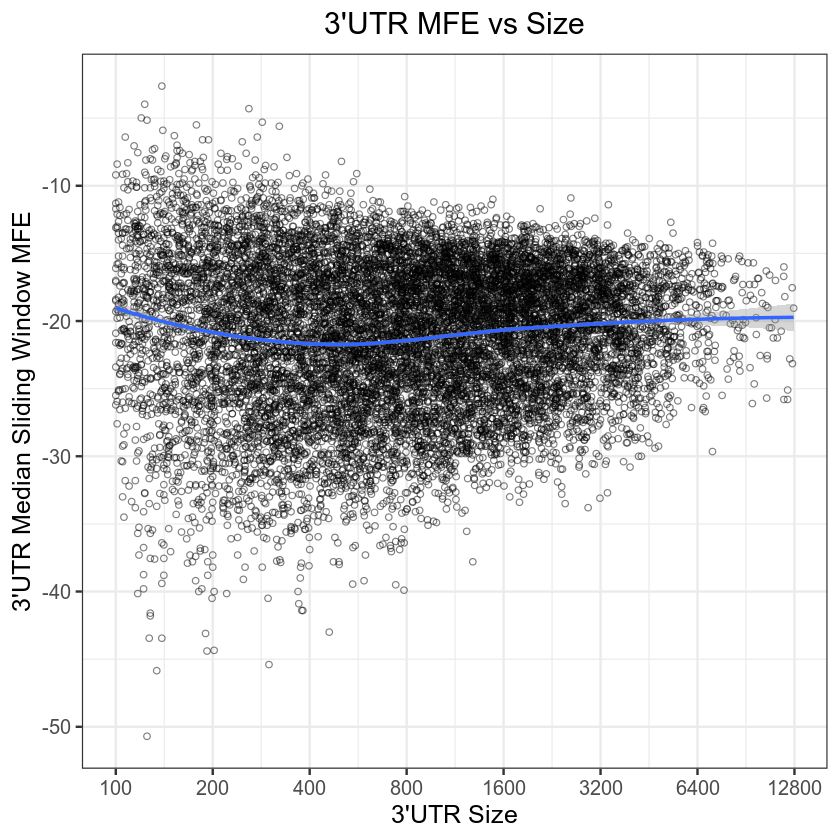

In [244]:
options(repr.plot.width=7, repr.plot.height=7)

df = pas %>%
 dplyr::filter(region == "3UTR", !is.na(window_mfe_median), UTR3_size < 12800) 

p = ggplot(df, aes(x=UTR3_size, y=window_mfe_median)) +
 geom_point(shape=1, alpha=0.5) +
 geom_smooth(method="loess") +
 xlab("3'UTR Size") +
 ylab("3'UTR Median Sliding Window MFE") +
 scale_x_log10(breaks=c(100, 200, 400, 800, 1600, 3200, 6400, 12800)) +
 ggtitle("3'UTR MFE vs Size")

p

Warning message:
“Removed 1 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 1 rows containing missing values (geom_point).”

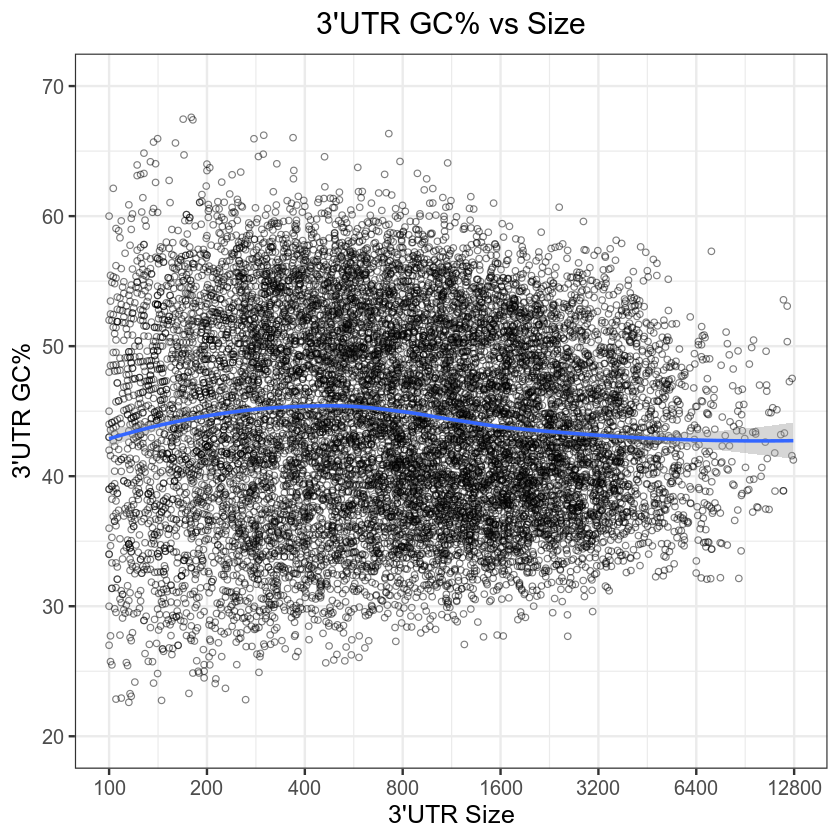

In [245]:
options(repr.plot.width=7, repr.plot.height=7)

df = pas %>%
 dplyr::filter(region == "3UTR", !is.na(UTR3_GC), 
                UTR3_size >= 100, UTR3_size < 12800) %>%
 mutate(UTR3_GC = UTR3_GC*100)

p = ggplot(df, aes(x=UTR3_size, y=UTR3_GC)) +
 geom_point(shape=1, alpha=0.5) +
 geom_smooth(method="loess") +
 xlab("3'UTR Size") +
 ylab("3'UTR GC%") +
 ylim(20, 70) +
 scale_x_log10(breaks=c(100, 200, 400, 800, 1600, 3200, 6400, 12800)) +
 ggtitle("3'UTR GC% vs Size")

p

## 21. Protein localization and mRNA features
The localization of encoded protein may also impact its mRNA metabolism. For example, mRNAs encoding membrane or secreted proteins tend to localize to the ER membrane. Moreover, mRNAs encoding proteins localizaed to different organells may have different features. Therefore it is important to have protein localization information in our *pas* dataframe for building machine learning models in Part-3.

If you have not downloaded and processed protein localization data before, the pipeline will download protein localization data from http://proteomics.ysu.edu/secretomes/animal/index.php and convert the Uniprot IDs into Gene Symbols using BioMart (slow). The processed data will be saved for future use. 

### 21. Get protein localization data

In [246]:
species = ifelse(GENOME %in% c("mm9", "mm10"), "mouse", 
                 ifelse(GENOME %in% c("hg18", "hg19", "hg38") | grepl("GRCh38", GENOME), 
                        "human", "other"))
# Download and process protein localization data for the first time
if(species == "other"){
    print("Currently this pipeline only supports mouse or human genome.")
    print("Please edit process_MetazSecKB.R to make it work for your species.")
}else if(!file.exists(file.path(SHARED_DATA_DIR, 
                                paste0(species, "_protein_localizations.csv")))){
    print("Processing database records for new species.")
    print("ID conversion may take a few hours.")
    source(file.path(MODULE_DIR, "process_MetazSecKB.R"))
}

A helper function that add protein localization to the df dataframe:

In [247]:
get_protein_localization = function(df = pas, localization_file){
  #` Add protein localization info to the dataframe df
    
  # df can contain poly(A) sites or pairs of poly(A) sites
  # The gene_symbol column in df is required for joining the dataframes
    
  require(dplyr)
  
  localizations = read.csv(localization_file, as.is = T) %>%
    distinct()

  m = localizations[, -grep("gene_symbol|localizations", names(localizations))]
    
  localizations = localizations %>%
    mutate(Other = as.integer(rowSums(m) == 0)) %>%
    dplyr::select(-localizations)
  
  names(localizations) = paste0("YSU.", names(localizations)) 

  names(localizations) = sub("YSU.gene_symbol", "gene_symbol", names(localizations)) 
  
  # Genes not found in localizations will be NA
  df = left_join(df, localizations, by="gene_symbol") 
  
  # pAs in introns, UA, etc should not be annotated with protein localization
  if("region" %in% names(df)){ 
    for(loc in grep("gene_symbol", names(localizations), value=T, invert=T)){
      df[df$region != "3UTR", loc] = NA
    }
  }
  df
}

Add protein localization information to the *pas* dataframe:

In [248]:
localization_file = file.path(SHARED_DATA_DIR, paste0(species, "_protein_localizations.csv"))

pas = get_protein_localization(pas, localization_file)

How do we know that the protein localization data make sense?

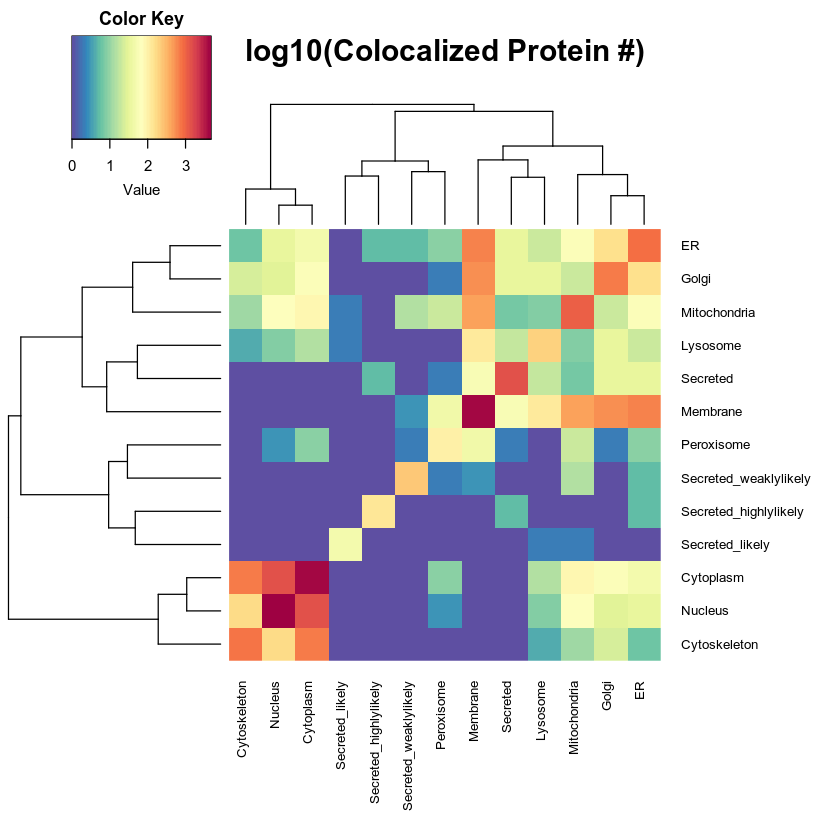

In [249]:
require(dplyr)
require(tidyr)

localizations = read.csv(localization_file, as.is = T) 

# Add "Other" localization
m = localizations[, -grep("gene_symbol|localizations", names(localizations))]
localizations = localizations %>%
  mutate(Other = as.integer(rowSums(m) == 0)) %>%
  distinct()

# Calculate colocalization matrix
colocalization = matrix(nrow = length(names(m)), ncol = length(names(m)))
colnames(colocalization) <- rownames(colocalization) <- names(m)
for(i in 1:length(names(m))){
  for(j in i:length(names(m))){
    colocalization[i, j] <- colocalization[j, i] <- sum(m[, i] == 1 & m[, j] == 1)
  }
}

# Plot heatmap
options(repr.plot.width=7, repr.plot.height=7)
colocalization = log10(colocalization+1)
colors = rev(brewer.pal(11, "Spectral"))
colors = colorRampPalette(colors)(100)
heatmap.2(colocalization, col=colors, 
          main = "log10(Colocalized Protein #)", 
          density.info = "none",
          trace="none", margins = c(9, 9), cexRow = 0.8, cexCol = 0.8)

# require(pheatmap)
# pheatmap(colocalization, 
#          display_numbers=T, 
#          main = "Clusters of Protein Colocalization", 
#          filename = file.path(result_dir, "Colocalization_clustered.png"))


From the above heatmap, we can see that some organelles (such as ER and Golgi) contain shared proteins and therefore are more similar to each other.

## 22. Calcualte RBP binding scores (RNAcompete and SELEX)

Download position weight matrix (PWM) from [ATtRACT](https://attract.cnic.es/attract/default/download#sec4):

In [259]:
# "jupyter shell" function
js = function(shell_command){
     cat(system(shell_command, intern=TRUE), sep='\n')
}

In [260]:
target_dir = paste0(SHARED_DATA_DIR, "/ATtRACT") 

if(!file.exists(target_dir)){
 url = "https://attract.cnic.es/attract/static/ATtRACT.zip"
 cmd = paste0("wget -P ", SHARED_DATA_DIR, " ", url)
 js(cmd)

 dir.create(target_dir)

 cmd = paste0("unzip ", SHARED_DATA_DIR, "/ATtRACT.zip -d ", target_dir)
 js(cmd)   
}



In [261]:
# Parallel computing
# Read RBP database files downloaded from the ATtRACT database
db = read.table(file.path(SHARED_DATA_DIR, "ATtRACT", "ATtRACT_db.txt"), 
                        sep = "\t", header = T, as.is = T) %>%
  dplyr::filter(Organism %in% c("Homo_sapiens", "Mus_musculus", "Rattus_norvegicus") 
                & Mutated == "no") %>%
  dplyr::select(Gene_name, Gene_id, Matrix_id) %>%
  unique() %>%
  mutate(ID = paste(Gene_name, Matrix_id, sep = "_"))


utr3 = subset(pas, !is.na(exonic_3UTR_seq), c(pAid, exonic_3UTR_seq))
seqs = DNAStringSet(utr3$exonic_3UTR_seq)
base_fraction = alphabetFrequency(seqs, as.prob=T)

# Remove 2 sequences that contain bases other than ATCG
mask = which(rowSums(base_fraction[, 5:ncol(base_fraction)]) == 0)
utr3 = utr3[mask, ]
seqs = seqs[mask]

# Read RBP database files downloaded from the ATtRACT database
db = read.table(file.path(SHARED_DATA_DIR, "ATtRACT", "ATtRACT_db.txt"), 
                        sep = "\t", header = T, as.is = T) %>%
  dplyr::filter(Organism %in% c("Homo_sapiens", "Mus_musculus", "Rattus_norvegicus") 
                & Mutated == "no" 
                & grepl("SELEX|RNAcompete", Experiment_description)) %>%
  dplyr::select(Gene_name, Matrix_id) %>%
  unique() %>%
  mutate(ID = paste(Gene_name, Matrix_id, sep = "_"))

# Prepare PWM
pwm_file = file.path(SHARED_DATA_DIR, "ATtRACT", "pwm.txt")
all_lines = readLines(pwm_file)
all.name.idx = grep("^>", all_lines)

# Scan 3'UTR sequences with PWM
library(doParallel)
cl = makeCluster(8)
registerDoParallel(cl)
# Parallel computation result is identical to sequential computation
utr3_score = foreach(i=1:nrow(db), .combine=cbind, .packages="Biostrings") %dopar% {
  id = db[i, "ID"] 
  pwm.id = db[i, "Matrix_id"] 
    
  name.idx = grep(paste0("^>", pwm.id, "\\t"), all_lines)
  idx.idx = which(all.name.idx == name.idx)
  pwm.lines = all_lines[(name.idx+1): (all.name.idx[idx.idx+1] - 1)]
  pwm = data.frame(to.split = pwm.lines, stringsAsFactors = F)
  pwm = apply(pwm, 1, function(row) as.numeric(strsplit(row, "\t")[[1]]))
  rownames(pwm) = c("A", "C", "G", "T")
  
  result_column = vector("numeric", nrow(utr3))             
  for(j in 1:nrow(utr3)){
    hits = matchPWM(pwm, seqs[[j]])
    scores = PWMscoreStartingAt(pwm, subject(hits), start(hits))
    result_column[j] = sum(scores)
  }   
  result_column
}
colnames(utr3_score) = db$ID
utr3_score = as.data.frame(utr3_score)
              
# Change column names             
for(rbp in unique(db$Gene_name)){
  ids = subset(db, Gene_name == rbp)$ID
  if(length(ids) > 1){
    utr3_score[, rbp] = rowMeans(utr3_score[, ids])
  }else{
    utr3_score[, rbp] = utr3_score[, ids]
  }
  utr3_score[, ids] = NULL
}
names(utr3_score) = paste0("RBP.", names(utr3_score))
utr3_score$pAid = utr3$pAid

In [265]:
pas = pas %>%
  left_join(utr3_score[, grep("pAid|^RBP", names(utr3_score))])

write.csv(pas, file.path(result_dir, paste0("pas.csv")), row.names = F)

Joining, by = "pAid"


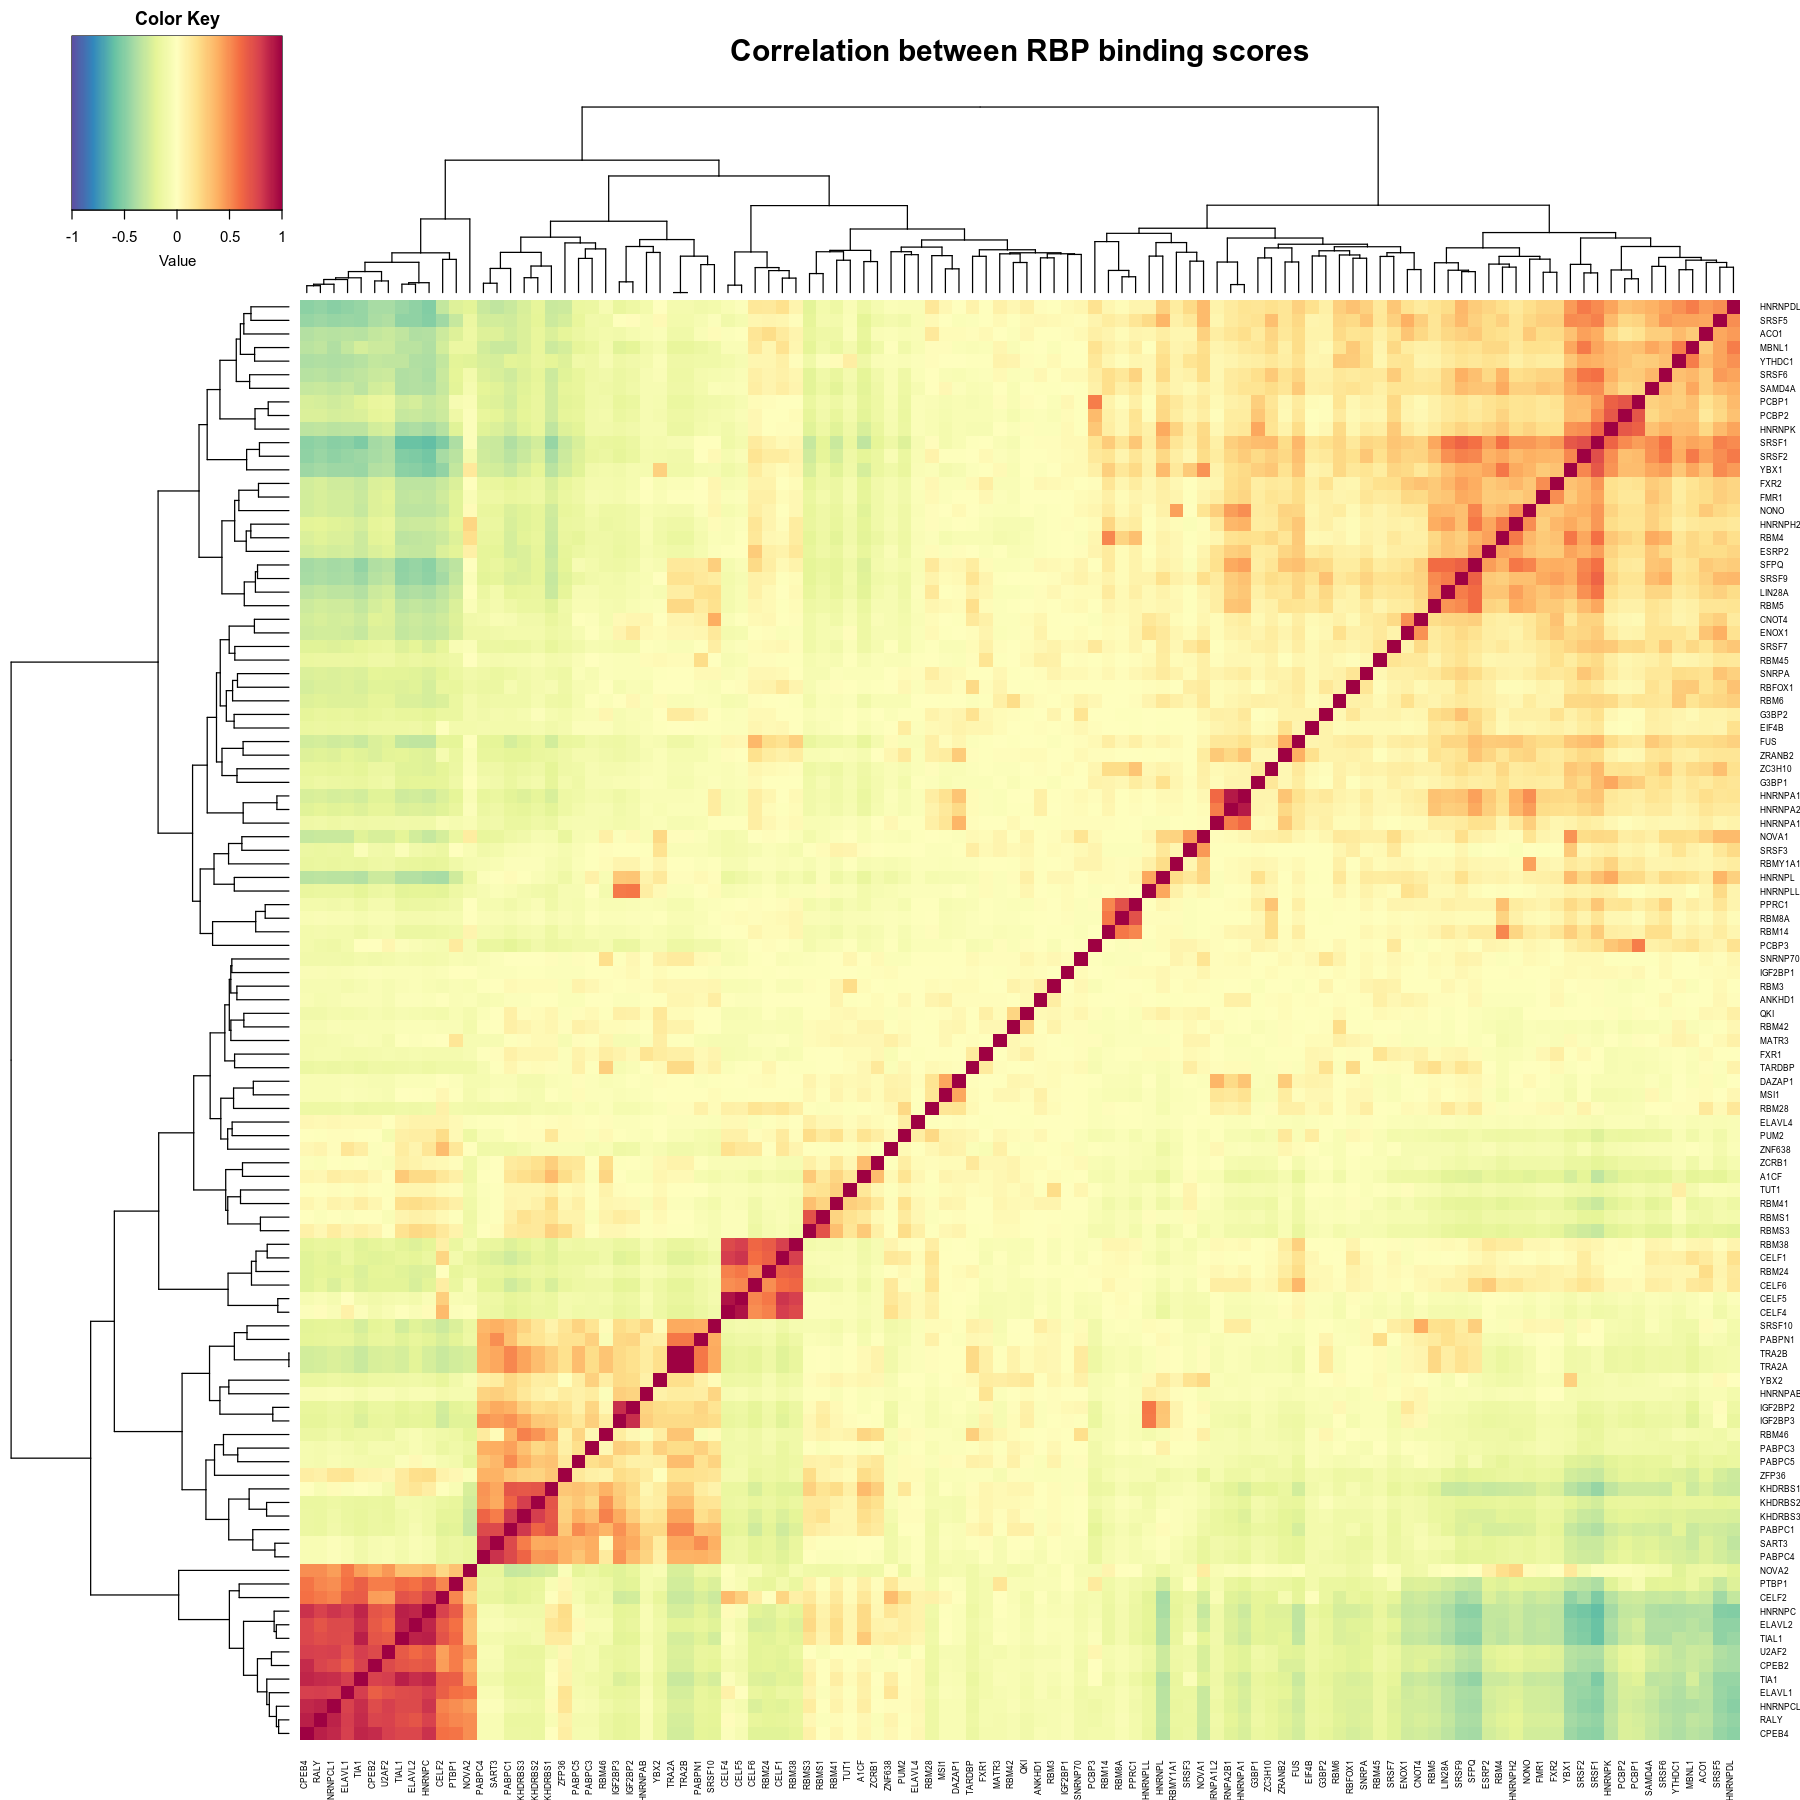

In [266]:
scores = pas %>%
  dplyr::select_at(vars(matches("^RBP\\."))) %>%
  drop_na() 

scores %<>%
  # Row-wise normalization is necessary because binding scores are affected by 3'UTR size
  mutate_all(~./rowSums(scores)) %>%
  drop_na() 

names(scores) = sub("RBP\\.", "", names(scores))

m = cor(scores)

# Plot heatmap
options(repr.plot.width=15, repr.plot.height=15)
colors = rev(brewer.pal(11, "Spectral"))
colors = colorRampPalette(colors)(200)
heatmap.2(m, col=colors, 
          main = "Correlation between RBP binding scores", 
          density.info = "none", keysize= 0.8,
          trace="none", margins = c(3, 3), cexRow = 0.5, cexCol = 0.5)


## 23. Annotate repeat elements (such as IRAlu) in 3'UTRs

Alu elements in human RNA, especially IRAlu (Inverted Repeat Alu), can form secondary structures that can be recognized by Stau1. The repeat makser file was manually downloaded from https://genome.ucsc.edu/cgi-bin/hgTables. 

In [267]:
get_hg19_Alu = function(df=pas, txdb_path,
                        repeat.table=file.path(SHARED_DATA_DIR, "hg19_rmsk"), 
                        ignore.intron.Alu = T, 
                        keep.alu.direction = F){
  #` A function to annotate Alu elements in hg19
    
  rmsk = read.table(repeat.table, header = T, sep = "\t", as.is = T, comment.char = "")
  alu = subset(rmsk, repFamily == "Alu", select = names(rmsk)[c(2:11, 14:16)])
  # If "strand" is "+": 
    # The sequence between "genoStart" and "genoEnd" on the positive strand 
    # is similar to the "repName"
  # If "strand" is "-": 
    # The sequence between "genoStart" and "genoEnd" on the minus strand 
    # is similar to the "repName"
  
  # If a 3'UTR is on the "+" strand and it contains an Alu element 
    # defined by ("genoName", "genoStart", "genoEnd", "strand"):
  #    if the Alu "strand" is "+": the Alu in 3'UTR is "S" (sense)
  #    if the Alu "strand" is "-": the Alu in 3'UTR is "AS" (anti-sense)
  # If a 3'UTR is on the "-" strand and it contains an Alu element
    # defined by ("genoName", "genoStart", "genoEnd", "strand"):
  #    if the Alu "strand" is "+": the Alu in 3'UTR is "AS" (anti-sense)
  #    if the Alu "strand" is "-": the Alu in 3'UTR is "S" (sense)
  
  alu$alu.id = 1:nrow(alu)
  
  # Map Alu to 3'UTRs
  require(GenomicRanges)
  pA.gr = create_3UTR_from_pAs(df)
    
  # Sense
  alu.s = alu[, c("genoName", "genoStart", "genoEnd", "strand", "repName", 
                  "repStart", "repEnd", "alu.id")] 
  names(alu.s) = c("chr", "start", "end", "strand", "repName", 
                   "repStart", "repEnd", "alu.id")
  alu.s.gr = makeGRangesFromDataFrame(alu.s, keep.extra.columns = T) 
    
  # Anti-sense
  alu.a = alu.s
  alu.a$strand = ifelse(alu.a$strand == "+", "-", "+")
  alu.a.gr = makeGRangesFromDataFrame(alu.a, keep.extra.columns = T) 
  
  # Remove alu in introns 
  if(ignore.intron.Alu){
    txdb = loadDb(txdb_path)
    introns = intronsByTranscript(txdb)
    alu.s.gr = subsetByOverlaps(alu.s.gr, introns, type = "within", invert = T)
    alu.a.gr = subsetByOverlaps(alu.a.gr, introns, type = "within", invert = T)
  }
  
  pA.alu.s = mergeByOverlaps(alu.s.gr, pA.gr, type="within")
  pA.alu.s$direction = "s"
  names(pA.alu.s)[1] = "alu.gr"
  
  pA.alu.a = mergeByOverlaps(alu.a.gr, pA.gr, type="within")
  pA.alu.a$direction = "a"
  names(pA.alu.a)[1] = "alu.gr"
  
  pA.alu = rbind(pA.alu.s, pA.alu.a)
  names(pA.alu) = sub("^pA.gr$", "utr3.gr", names(pA.alu))
  pA.alu$alu.gr = as.character(pA.alu$alu.gr)     
  pA.alu$utr3.gr = as.character(pA.alu$utr3.gr)  
  
  require(dplyr)
  require(tidyr)
  alu.df = as.data.frame(pA.alu) %>% 
    mutate(signed.start = as.numeric(sub(".+?:(\\d+?)-\\d+:([+-])", "\\2\\1", alu.gr))) %>% 
    group_by(gene_symbol, pAid, utr3.gr) %>%
    arrange(signed.start) %>%
    summarize(num_Alu = n(), 
              alu.directions = paste(direction, collapse=";"), 
              repNames = paste(repName, collapse=";"), 
              alu.ids = paste(alu.id, collapse=";"),
              alu.grs = paste(alu.gr, collapse=";")) %>%
    dplyr::filter(num_Alu < 100)
  
  
  alu.df$alu.s = !is.na(alu.df$alu.directions) & !grepl("a", alu.df$alu.directions) 
  alu.df$alu.a = !is.na(alu.df$alu.directions) & !grepl("s", alu.df$alu.directions)
  alu.df$alu.a.s = !is.na(alu.df$alu.directions) & grepl("a;s", alu.df$alu.directions)
  alu.df$alu.s.a = !is.na(alu.df$alu.directions) & grepl("s;a", alu.df$alu.directions) 
  
  require(stringr)
  # Number of possible pairs of a/s or s/a is the min of number of s and number of a.
  alu.df$num_IRAlu = pmin(str_count(alu.df$alu.directions, pattern = "s"),
                          str_count(alu.df$alu.directions, pattern = "a"))
  
  alu.df$Alu_type = ifelse(alu.df$alu.a.s | alu.df$alu.s.a, "IRAlu", alu.df$num_Alu)
  alu.df$Alu_type[!alu.df$Alu_type %in% c("1", "2", "IRAlu")] = ">=3"
  
  cols = c("pAid", "Alu_type", "num_Alu", "num_IRAlu", "alu.s", "alu.a", "alu.a.s", "alu.s.a")
  if(keep.alu.direction){
    cols = c(cols, "alu.directions")
  }
  
  alu.df = alu.df[, cols]
  df = merge(df, alu.df, by = "pAid", all.x=T)
  df$Alu_type[is.na(df$Alu_type)] = "0"
  df$num_Alu[is.na(df$num_Alu)] = 0
  df$num_IRAlu[is.na(df$num_IRAlu)] = 0
  
  df
}


Only annotate Alu and IRAlu for human samples:

In [268]:
if(GENOME == "hg19"){
    pas = get_hg19_Alu(pas)
}

## 24. Use DESeq2 to transform data and calcualte pA site fold change (FC).

Many common statistical methods for exploratory analysis of multidimensional data, for example clustering and principal components analysis (PCA), work best for data that generally has the same range of variance at different ranges of the mean values. When the expected amount of variance is approximately the same across different mean values, the data is said to be homoskedastic. For RNA-seq counts, however, the expected variance grows with the mean. For example, **if one performs PCA directly on a matrix of counts or normalized counts (e.g. correcting for differences in sequencing depth), the resulting plot typically depends mostly on the genes with highest counts because they show the largest absolute differences between samples.** A simple and often used strategy to avoid this is to take the logarithm of the normalized count values plus a pseudocount of 1; however, depending on the choice of pseudocount, now the genes with the very lowest counts will contribute a great deal of noise to the resulting plot, because taking the logarithm of small counts actually inflates their variance. 

As a solution, DESeq2 offers two transformations for count data that stabilize the variance across the mean: the regularized-logarithm transformation or rlog (Love, Huber, and Anders 2014), and the variance stabilizing transformation (VST) for negative binomial data with a dispersion-mean trend (Anders and Huber 2010), implemented in the vst function. For genes with high counts, the rlog and VST will give similar result to the ordinary log2 transformation of normalized counts. For genes with lower counts, however, the values are shrunken towards the genes’ averages across all samples. The rlog-transformed or VST data then becomes approximately homoskedastic, and can be used directly for computing distances between samples, making PCA plots, or as input to downstream methods which perform best with homoskedastic data. **The rlog tends to work well on small datasets (n < 30), sometimes outperforming the VST when there is a large range of sequencing depth across samples (an order of magnitude difference).** 

**Note that the two transformations offered by DESeq2 are provided for applications other than differential testing. For differential testing we recommend the DESeq function applied to raw counts, which also takes into account the dependence of the variance of counts on the mean value during the dispersion estimation step.**

### 24.1. rlog transformation

In [269]:
require(DESeq2)
require(GenomicAlignments)
  
# Starting from count matrices
counts = as.matrix(pas[, grep("_count$", names(pas), value=T)])
colnames(counts) = sub("_count$", "", colnames(counts))
rownames(counts) = pas$pAid
 
colData = DataFrame(Fraction=factor(sub("(.+)_(.+)_(.+)", "\\2", colnames(counts))),
                    Batch= factor(sub("(.+)_(.+)_(.+)", "\\3", colnames(counts))),
                    row.names=colnames(counts))

dds = DESeqDataSetFromMatrix(countData = counts,
                             colData = colData,
                             design = ~ Batch + Fraction)
  
  
## Pre-filtering the dataset
# Additional weighting/filtering to improve power is applied at a later step.
dds = dds[rowSums(counts(dds)) > 1, ]

In [270]:
rld = rlog(dds, blind = FALSE)
  
dds = estimateSizeFactors(dds)

### 24.2. Cluster samples using transformed data

We can see that batch 1 samples ("NT_C_1" and "NT_N_1") form a cluster, indicating some batch effects.

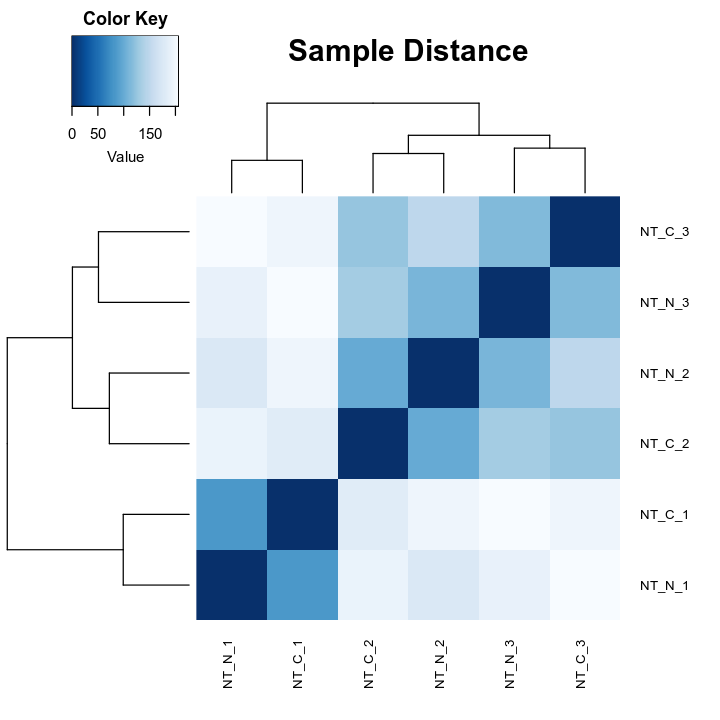

In [271]:
# Sample distances
sampleDists = dist(t(assay(rld)))

# Plot heatmap
options(repr.plot.width=ncol(dds), repr.plot.height=ncol(dds))
colors = rev(brewer.pal(9, "Blues"))
colors = colorRampPalette(colors)(100)
heatmap.2(as.matrix(sampleDists), col=colors, 
          main = "Sample Distance", 
          density.info = "none", trace="none", 
          margins = c(5, 5), cexRow = 0.8, cexCol = 0.8)

"NT_C_1" and "NT_N_1" are similar in PC1, but they are seperated in PC2:

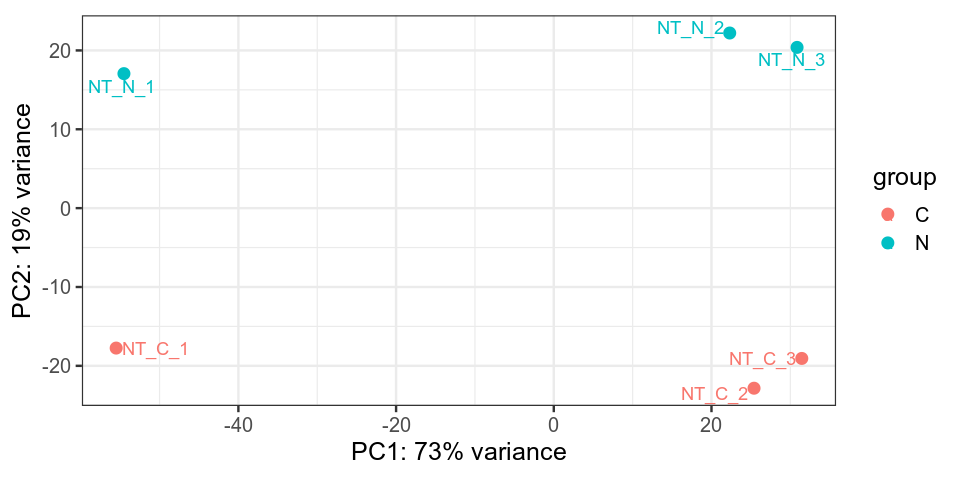

In [272]:
# PCA plot
plot_data = plotPCA(rld, intgroup = "Fraction", returnData=T) 

options(repr.plot.width=8, repr.plot.height=4)
plotPCA(rld, intgroup = "Fraction") + geom_text_repel(aes(x=PC1,y=PC2,label=name))

### 24.3. Use DESeq2 to calculate pA site fold changes (FC) across fractions

In [279]:
# Calculate fold change across FRACTIONS
if(length(FRACTIONS) > 1){
  for(treatment in TREATMENTS){
      for(i in 1:length(FRACTIONS[-1])){
        for(j in (i+1):length(FRACTIONS)){
          # only keep desirable comparisons
          if((paste(FRACTIONS[j], FRACTIONS[i], sep="_") %in% COMPARISONS) | 
             !exists("COMPARISONS")){
              counts = as.matrix(pas[, grep(paste0(treatment, ".+_count$"), 
                                            names(pas), value=T)])
              colnames(counts) = sub("_count$", "", colnames(counts))
              rownames(counts) = pas$pAid
 
              colData = DataFrame(Fraction=factor(sub("(.+)_(.+)_(.+)", "\\2", 
                                                      colnames(counts))),
                                  Batch= factor(sub("(.+)_(.+)_(.+)", "\\3", 
                                                    colnames(counts))),
                                  row.names=colnames(counts))

              dds = DESeqDataSetFromMatrix(countData = counts,
                                           colData = colData,
                                           design = ~ Batch + Fraction)
  
              dds = dds[rowSums(counts(dds)) > 1, ]
              
              rld = rlog(dds, blind = FALSE)
  
              dds = estimateSizeFactors(dds)
              
              dds = DESeq(dds)

              # "contrast": a vector of the name of the variable,
              # the name of the level for the numerator,
              # and the name of the level for the denominator.
              contrast = c("Fraction", FRACTIONS[j], FRACTIONS[i])
              res = results(dds, contrast = contrast)
              res = data.frame(pAid = rownames(res), FC = res$log2FoldChange, stringsAsFactors=F)
              names(res) = sub("FC", paste(treatment, FRACTIONS[j], FRACTIONS[i], 
                                           "FC", sep="_"), names(res))
              if(names(res)[2] %in% names(pas)){
                  pas[, names(res)[2]] = NULL
              }
              pas %<>% left_join(res)
          }
        }
      }
    }
  }

using pre-existing size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
Joining, by = "pAid"


### 24.4. Use DESeq2 to calculate pA site fold changes (FC) across treatments

In [280]:
# Calculate fold change across TREATMENTS
if(length(TREATMENTS) > 1){
  for(fraction in FRACTIONS){
      for(i in 1:length(TREATMENTS[-1])){
        for(j in (i+1):length(TREATMENTS)){
          # only keep desirable comparisons
          if((paste(TREATMENTS[j], TREATMENTS[i], sep="_") %in% COMPARISONS) | 
             !exists("COMPARISONS")){
              counts = as.matrix(pas[, grep(paste0(fraction, ".+_count$"), 
                                            names(pas), value=T)])
              colnames(counts) = sub("_count$", "", colnames(counts))
              rownames(counts) = pas$pAid
 
              colData = DataFrame(Treatment=factor(sub("(.+)_(.+)_(.+)", "\\1", 
                                                      colnames(counts))),
                                  Batch= factor(sub("(.+)_(.+)_(.+)", "\\3", 
                                                    colnames(counts))),
                                  row.names=colnames(counts))

              dds = DESeqDataSetFromMatrix(countData = counts,
                                           colData = colData,
                                           design = ~ Batch + Treatment)
  
  
              dds = dds[rowSums(counts(dds)) > 1, ]
              
              rld = rlog(dds, blind = FALSE)
  
              dds = estimateSizeFactors(dds)
              
              dds = DESeq(dds)

              # "contrast": a vector of the name of the variable,
              # the name of the level for the numerator,
              # and the name of the level for the denominator.
              contrast = c("Treatment", TREATMENTS[j], TREATMENTS[i])
              res = results(dds, contrast = contrast)
              res = data.frame(pAid = rownames(res), FC = res$log2FoldChange, stringsAsFactors=F)
              names(res) = sub("FC", paste(fraction, TREATMENTS[j], TREATMENTS[i], 
                                           "FC", sep="_"), names(res))
              
              if(names(res)[2] %in% names(pas)){
                  pas[, names(res)[2]] = NULL
              }
              
              pas %<>% left_join(res)
          }
        }
      }
    }
  }

In [281]:
write.csv(pas, file.path(result_dir, "pas.csv"), row.names=F)

**This is the end of Part-2 of the pipeline. The features such as sizes, GC%, RBP binding scores, and protein localizations in the *pas* data frame can be used in machine learning models to predict experimental outcomes such as pA site folde changes accross treatments or fractions.**